In [1]:

import pandas as pd

# tulostusasetukset niin, että kaikki rivit ja sarakkeet näkyvät

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


In [2]:
import geopandas as gpd

# Shapefile joen keskiviiva
joen_keskiviiva = gpd.read_file(r'C:\Users\oonao\Documents\lipasto\5_vuosi\gradu\gis\joki_centerline2_clip.shp')

print(joen_keskiviiva)

   FID_  FID_joki_S        pituus  InLine_FID    SHAPE_Leng   
0     1           0  32603.797962           1  29791.888251  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

<Axes: >

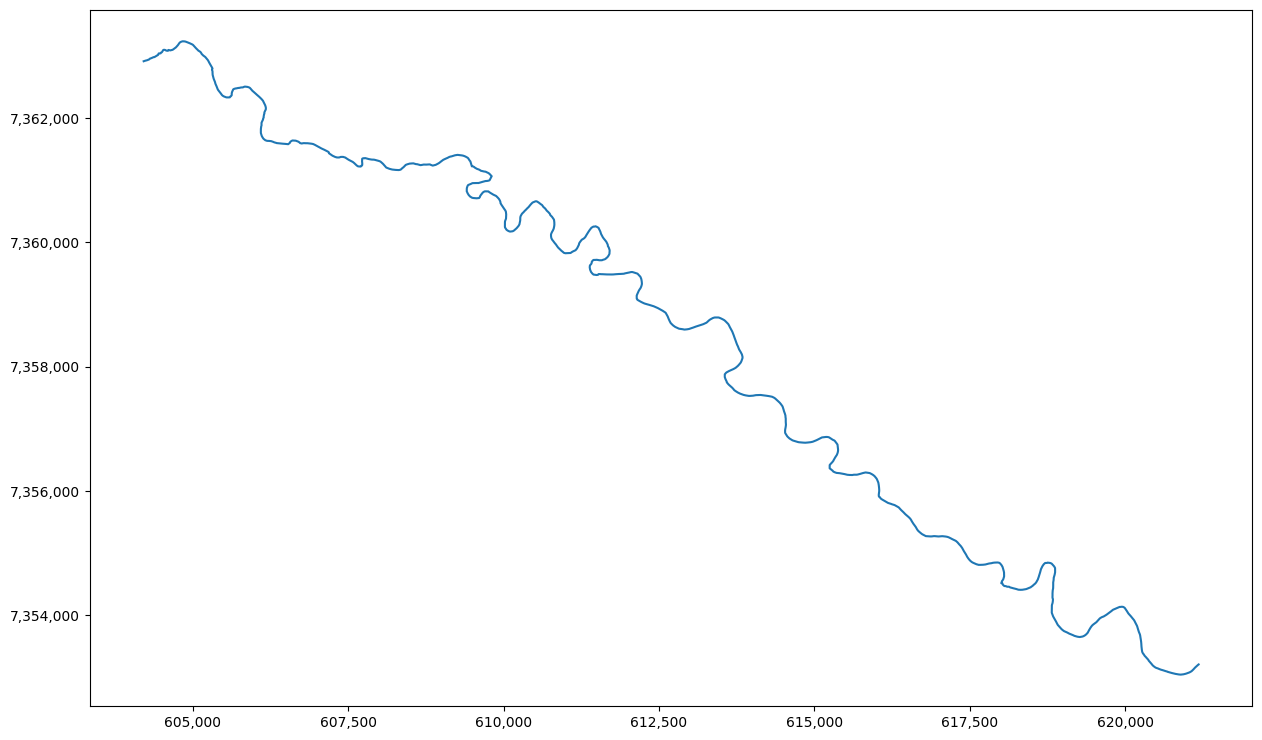

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Kuvakoko
fig, ax = plt.subplots(figsize=(15, 10))

# x ja y akselit
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

# Joen plottaus
joen_keskiviiva.plot(ax=ax)

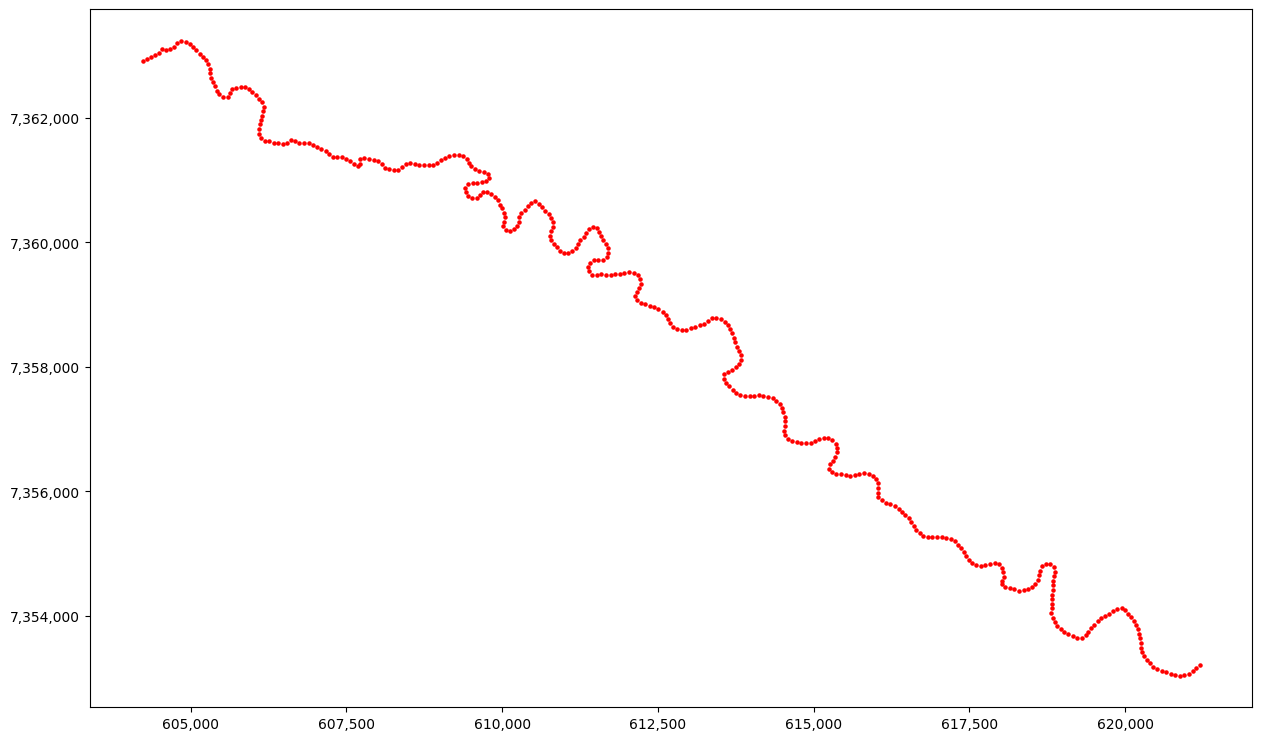

In [4]:
from shapely.geometry import LineString

# Kuvakoko, kaksi kuvaa
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 20))
fig, ax = plt.subplots(figsize=(15, 15))
# x ja y akselit
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))


# GeoDataFrame pisteitä varten 
pisteet100 = gpd.GeoDataFrame(columns=['geometry'])

#funktio jakopisteiden luomiselle
def create_breakpoints(geometry, interval):

    breakpoint = LineString(geometry).interpolate(range(0, int(geometry.length), interval))

    #Lisää point geodataframeen
    point = gpd.GeoDataFrame(geometry=list(breakpoint), crs='EPSG:3067')
    return point[::-1]


# Jaa 100m välein
pisteet100 = create_breakpoints(joen_keskiviiva['geometry'].iloc[0], 75)


# Plottaa point
pisteet100.plot(ax=ax, color='red', marker='o', markersize=5)


# Näytä kaavio
plt.show()


388    POINT (604229.967 7362917.975)
387    POINT (604299.429 7362943.425)
386    POINT (604365.979 7362975.956)
385    POINT (604431.406 7363008.918)
384    POINT (604486.150 7363045.855)
383    POINT (604537.428 7363094.881)
382    POINT (604605.222 7363088.635)
381    POINT (604674.804 7363095.071)
380    POINT (604733.944 7363140.642)
379    POINT (604780.436 7363199.273)
378    POINT (604845.125 7363231.432)
377    POINT (604917.319 7363213.775)
376    POINT (604986.034 7363183.782)
375    POINT (605040.215 7363132.843)
374    POINT (605092.963 7363079.807)
373    POINT (605144.020 7363027.223)
372    POINT (605200.848 7362978.653)
371    POINT (605247.414 7362920.021)
370    POINT (605283.354 7362854.206)
369    POINT (605314.133 7362788.467)
368    POINT (605317.866 7362716.679)
367    POINT (605331.932 7362643.363)
366    POINT (605357.610 7362573.016)
365    POINT (605383.728 7362502.949)
364    POINT (605416.560 7362436.048)
363    POINT (605462.283 7362376.605)
362    POINT

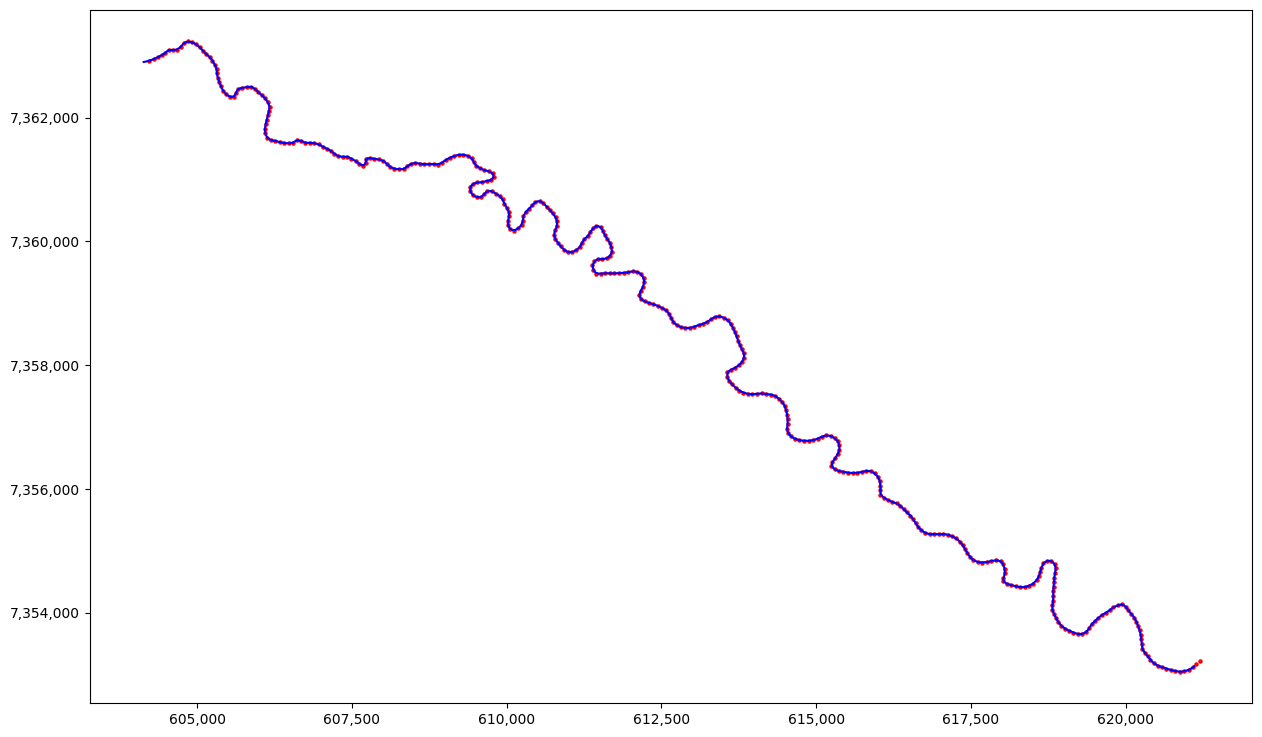

In [5]:
import geopandas as gpd
import numpy as np
from scipy.interpolate import BSpline
from shapely.geometry import LineString, Point
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter  # Import FuncFormatter explicitly

def create_nurbs(points):
    x, y = zip(*points)

    # Use spline and do not allow extrapolation
    t = np.linspace(0, 1, len(points))
    spl = BSpline(t, list(zip(x, y)), 2, extrapolate=True)

    t_new = np.linspace(0, 1, 600)
    spline_points = [Point(coord) for coord in zip(spl(t_new)[:, 0], spl(t_new)[:, 1])]


    bspline = LineString(spline_points)
    bspline_gdf = gpd.GeoDataFrame(geometry=list(spline_points))
   

    return bspline, bspline_gdf

# Generate NURBS curve
spline100, spline100_gdf = create_nurbs(pisteet100['geometry'].apply(lambda point: (point.x, point.y)).tolist())
print(pisteet100['geometry'])

# Plotting
fig, ax = plt.subplots(figsize=(15, 12))

# x and y axes formatting
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

# Plot NURBS line
gpd.GeoDataFrame(geometry=[spline100]).plot(ax=ax, color='blue')

# Plot points
pisteet100.plot(ax=ax, color='red', marker='o', markersize=5)

plt.show()


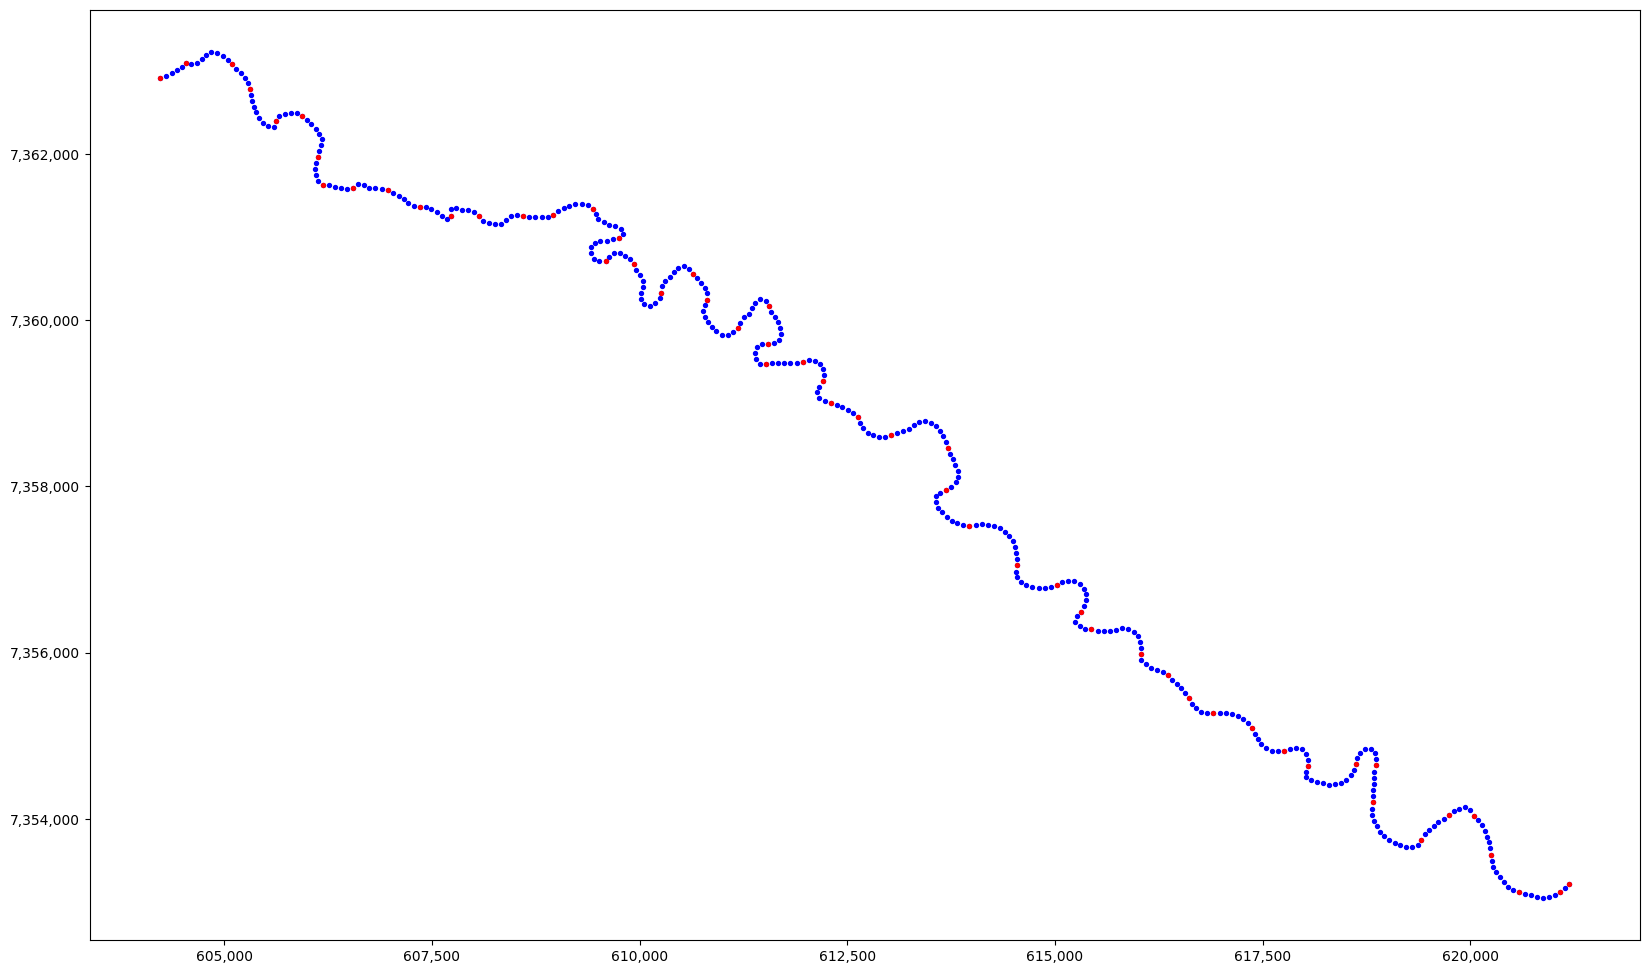

In [6]:
#KÄÄNNEpoints f(xi)=(x_{i-1} - x_i)*(x_i - x_{i+1})T avulla, Analyyttinen geometria 2016 s.6
import numpy as np
from numpy import linalg

def define_inflectionpoints(points, p_between):
    inflectionpoint_list = []
    points_in_between=0
    inflectionpoint_list.append(points.iloc[0]) #eka

    for i in range(1, len(points)-2):
        v1 = (np.array(points.iloc[i-1].coords[0])) - (np.array(points.iloc[i].coords[0]))
        v2 = (np.array(points.iloc[i].coords[0])) - (np.array(points.iloc[i+1].coords[0]))
        v2_orto = np.array([-v2[1], v2[0]])
        
        v3 = (np.array(points.iloc[i+1].coords[0])) - (np.array(points.iloc[i+2].coords[0]))
        v3_orto = np.array([-v3[1], v3[0]])


        dot_product1 = np.dot(v1, v2_orto)
        dot_product2 = np.dot(v2, v3_orto)

        points_in_between = points_in_between + 1
        
        if np.sign(dot_product1) != np.sign(dot_product2)  and points_in_between > p_between:
            inflectionpoint_list.append(points.iloc[i])
            
            points_in_between = 0
    inflectionpoint_list.append(points.iloc[len(points)-1]) #vipa
    
    return inflectionpoint_list


#Etsitään käännepoints
kaannepisteet100 = define_inflectionpoints(pisteet100['geometry'], 4)


# Kuvakoko, kaksi kuvaa
fig, ax = plt.subplots(figsize=(20, 15))

# x ja y akselit
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

# Piirrä muut points sinisenä
#pisteet200.plot(ax=ax, color='blue', marker='o', markersize=8, label='points p_i')
pisteet100.plot(ax=ax, color='blue', marker='o', markersize=8, label='points p_i')


# Piirrä käännepoints punaisena
#gpd.GeoDataFrame(geometry=kaannepisteet200).plot(ax=ax1, color='red', marker='o', markersize=8, label='Käännepoints')
gpd.GeoDataFrame(geometry=kaannepisteet100).plot(ax=ax, color='red', marker='o', markersize=8, label='Käännepoints')

plt.show()


In [7]:
#points, janat, keskinormaalit, leikkauspisteet, ympyrän säde

import numpy as np


def radius_and_intersectionpoint(points):
    radius_list = []
    intersectionpoint_list = []


    for i in range(len(points) - 2):

        # kolme peräkkäistä pistettä
        p1 = np.array(points['geometry'].iloc[i].coords[0])
        p2 = np.array(points['geometry'].iloc[i + 1].coords[0])
        p3 = np.array(points['geometry'].iloc[i + 2].coords[0])

        # Lasketaan janojen keskinormaalien leikkauspiste
        midpoint1 = 0.5 * (p1 + p2)
        normal1 = np.array([-(p2 - p1)[1], (p2 - p1)[0]])

        midpoint2 = 0.5 * (p2 + p3)
        normal2 = np.array([-(p3 - p2)[1], (p3 - p2)[0]])

        # Muodostetaan yhtälöpari
        A = np.array([[normal1[0], -normal2[0]], [normal1[1], -normal2[1]]])
        B = np.array([midpoint2[0] - midpoint1[0], midpoint2[1] - midpoint1[1]])
        if np.linalg.det(A) == 0:
            print("Singular matrix. Skipping this point.")
            continue
        else:
        # Ratkaistaan yhtälöpari
            solution = np.linalg.solve(A, B)

            # Lasketaan leikkauspiste
            intersection_points = midpoint1 + solution[1] * normal1
            intersectionpoint_list.append(intersection_points)
        
            # Lasketaan ympyrän keskipiste ja säde
            radius = np.linalg.norm(intersection_points - p2)
            radius_list.append(radius)

    return radius_list, intersectionpoint_list, solution, A, B 

sade100, inter100, sol100, A100, B100 = radius_and_intersectionpoint(pisteet100)

print("R 100:", sade100)




R 100: [714.9336734920693, 6193.802895332761, 609.3778385505352, 376.88149158471424, 87.37668437636523, 365.5594853881627, 121.48062090297255, 306.5913178293351, 174.8954219709695, 103.69335247389081, 431.55039862698766, 220.55390782452955, 2210.195954480292, 6287.683880963316, 781.2158920997515, 388.8480290536847, 437.09481750128367, 1230.9896917136653, 190.18037626360064, 513.1513646924225, 465.07633308234375, 11003.8203734457, 753.7314769231841, 373.07681781332997, 232.2922064370927, 138.0200896787532, 67.54904698109473, 2993.7696533527555, 84.37116337046561, 591.0898495914997, 4744.244444725039, 112.24023491444122, 310.38399273532696, 1396.047722954404, 3108.9175484779935, 340.918756211155, 375.12702847680464, 133.3500581605844, 1195.8683183811206, 4750.403697263518, 156614.79701174016, 634.2835010095832, 402.46662450309003, 204.26913424034507, 142.05591118636505, 142.34221010361838, 319.80479046183945, 397.4710135972763, 1230.239670747978, 366.94519074623815, 124.49251037862435, 8

                           geometry  curvature
388  POINT (604229.967 7362917.975)        NaN
387  POINT (604299.429 7362943.425)   0.001399
386  POINT (604365.979 7362975.956)   0.000161
385  POINT (604431.406 7363008.918)   0.001641
384  POINT (604486.150 7363045.855)   0.002653
383  POINT (604537.428 7363094.881)   0.011445
382  POINT (604605.222 7363088.635)   0.002736
381  POINT (604674.804 7363095.071)   0.008232
380  POINT (604733.944 7363140.642)   0.003262
379  POINT (604780.436 7363199.273)   0.005718
378  POINT (604845.125 7363231.432)   0.009644
377  POINT (604917.319 7363213.775)   0.002317
376  POINT (604986.034 7363183.782)   0.004534
375  POINT (605040.215 7363132.843)   0.000452
374  POINT (605092.963 7363079.807)   0.000159
373  POINT (605144.020 7363027.223)   0.001280
372  POINT (605200.848 7362978.653)   0.002572
371  POINT (605247.414 7362920.021)   0.002288
370  POINT (605283.354 7362854.206)   0.000812
369  POINT (605314.133 7362788.467)   0.005258
368  POINT (6

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


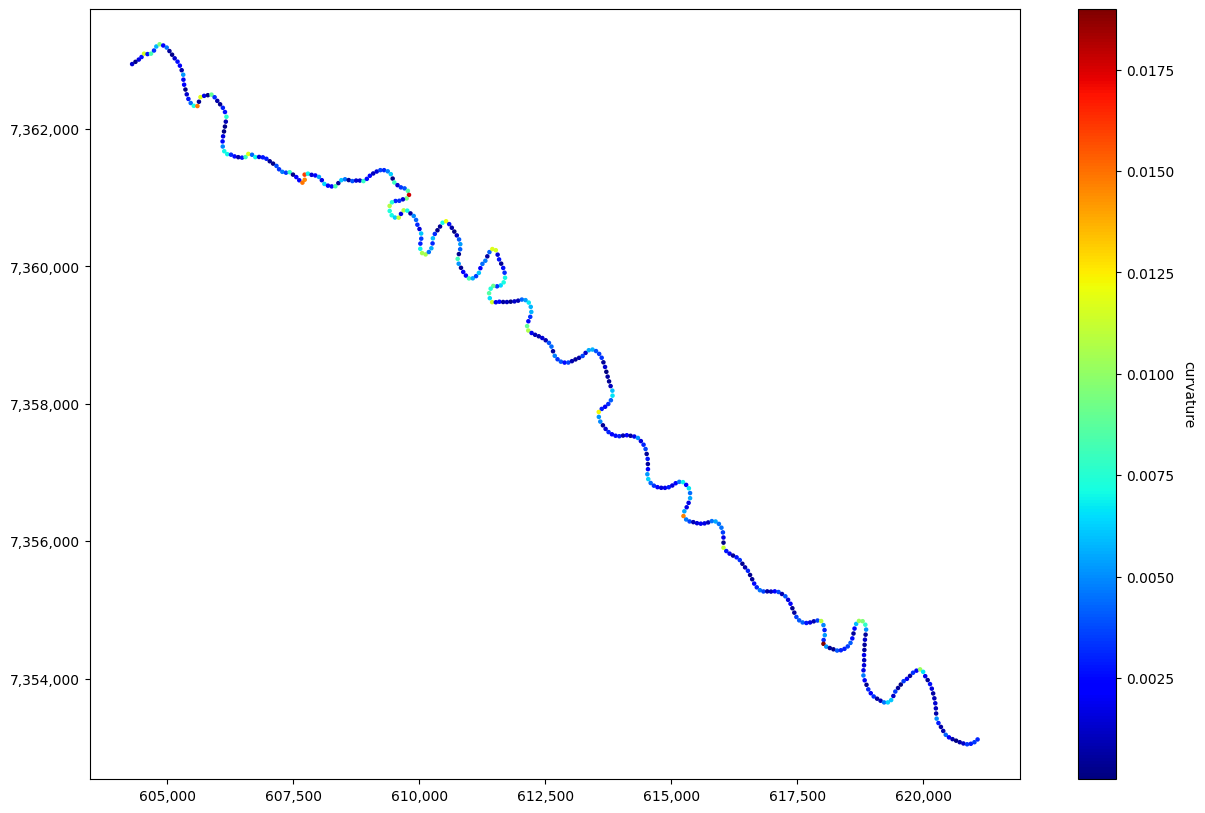

In [8]:
#KAAAREVUUUS 1/R 100


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def calculate_curvature(points, radius):
    curvature_list = []
    shifted_radius = [np.nan] + radius[:-1]

    points['curvature'] = np.nan

    for i in range(len(points) - 2):
        radius = shifted_radius[i]
        curvature = 1 / radius
        curvature_list.append(curvature)

    # Kaarevuusarvoja ei kahdelle ekalle pisteessä
    points['curvature'][:-2] = curvature_list


calculate_curvature(pisteet100, sade100)

print(pisteet100)


fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(
    pisteet100.geometry.x,
    pisteet100.geometry.y,
    c=pisteet100['curvature'],
    cmap='jet',
    s=5
)

    # Lisää värikartan selitys
cbar = plt.colorbar(scatter, label='Curvature')
cbar.set_label('curvature', rotation=270, labelpad=15)

    # x ja y akselit
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

plt.show()


In [9]:
#MÄÄRITELLÄÄN halfmeander

def define_halfmeander(points, inflectionpoints):
    points['halfmeander'] = None
    halfmeander_id = 0
    j = 1

    for i in range(len(points['geometry'])):
        if points['geometry'].iloc[i].coords[0] == inflectionpoints[j].coords[0]:
            points.at[len(points) - i - 1, 'halfmeander'] = halfmeander_id
            halfmeander_id += 1
            if j != len(inflectionpoints) - 1:
                j += 1
        else:
            points.at[len(points) - i - 1, 'halfmeander'] = halfmeander_id

# Example usage for 200m interval
# define_halfmeander(pisteet200, kaannepisteet200)

# Example usage for 200m interval
define_halfmeander(pisteet100, kaannepisteet100)

print(pisteet100)



                           geometry  curvature halfmeander
388  POINT (604229.967 7362917.975)        NaN           0
387  POINT (604299.429 7362943.425)   0.001399           0
386  POINT (604365.979 7362975.956)   0.000161           0
385  POINT (604431.406 7363008.918)   0.001641           0
384  POINT (604486.150 7363045.855)   0.002653           0
383  POINT (604537.428 7363094.881)   0.011445           0
382  POINT (604605.222 7363088.635)   0.002736           1
381  POINT (604674.804 7363095.071)   0.008232           1
380  POINT (604733.944 7363140.642)   0.003262           1
379  POINT (604780.436 7363199.273)   0.005718           1
378  POINT (604845.125 7363231.432)   0.009644           1
377  POINT (604917.319 7363213.775)   0.002317           1
376  POINT (604986.034 7363183.782)   0.004534           1
375  POINT (605040.215 7363132.843)   0.000452           1
374  POINT (605092.963 7363079.807)   0.000159           1
373  POINT (605144.020 7363027.223)   0.001280          

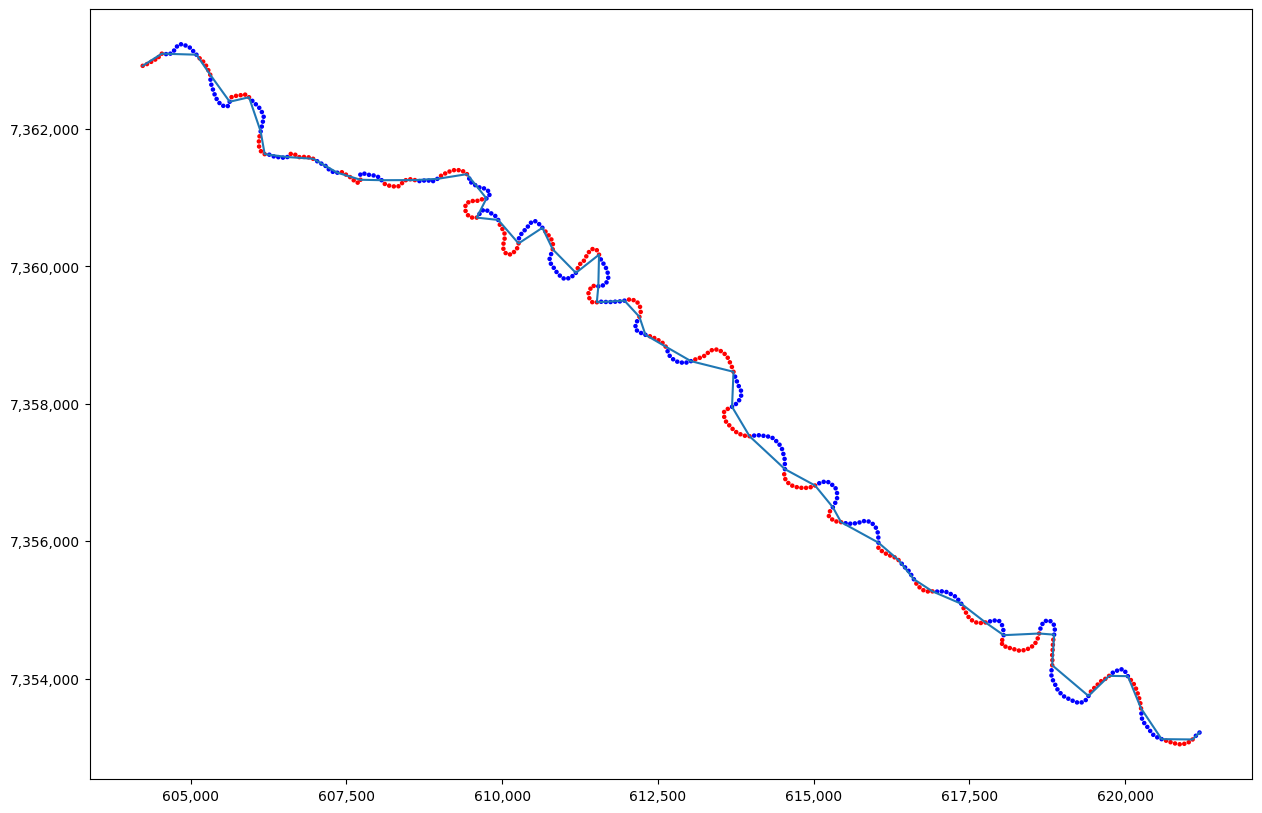

In [10]:
#Erottaa väreillä puolimeanderit ja plottaa

from matplotlib.colors import ListedColormap

colors = ['red' if i % 2 == 0 else 'blue' for i in range(pisteet100['halfmeander'].nunique())]
cmap = ListedColormap(colors)

fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(
    pisteet100.geometry.x,
    pisteet100.geometry.y,
    c=pisteet100['halfmeander'],
    cmap=cmap,
    s=5
)
#JANAT KÄÄNNEPISTEIDEN VÄLIIN
# Erota x- ja y-koordinaatit
kaanne100_x_coordinates = [point.x for point in kaannepisteet100]
kaanne100_y_coordinates = [point.y for point in kaannepisteet100]
# Piirrä janat pisteiden välille
plt.plot(kaanne100_x_coordinates, kaanne100_y_coordinates, linestyle='-')

# Aseta x- ja y-akselien muotoilu
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))



plt.show()

                           geometry  curvature halfmeander norm_curvature
388  POINT (604229.967 7362917.975)        NaN           0            NaN
387  POINT (604299.429 7362943.425)   0.001399           0       0.122216
386  POINT (604365.979 7362975.956)   0.000161           0       0.014107
385  POINT (604431.406 7363008.918)   0.001641           0       0.143387
384  POINT (604486.150 7363045.855)   0.002653           0       0.231841
383  POINT (604537.428 7363094.881)   0.011445           0            1.0
382  POINT (604605.222 7363088.635)   0.002736           1       0.283657
381  POINT (604674.804 7363095.071)   0.008232           1       0.853579
380  POINT (604733.944 7363140.642)   0.003262           1       0.338214
379  POINT (604780.436 7363199.273)   0.005718           1       0.592888
378  POINT (604845.125 7363231.432)   0.009644           1            1.0
377  POINT (604917.319 7363213.775)   0.002317           1       0.240281
376  POINT (604986.034 7363183.782)   

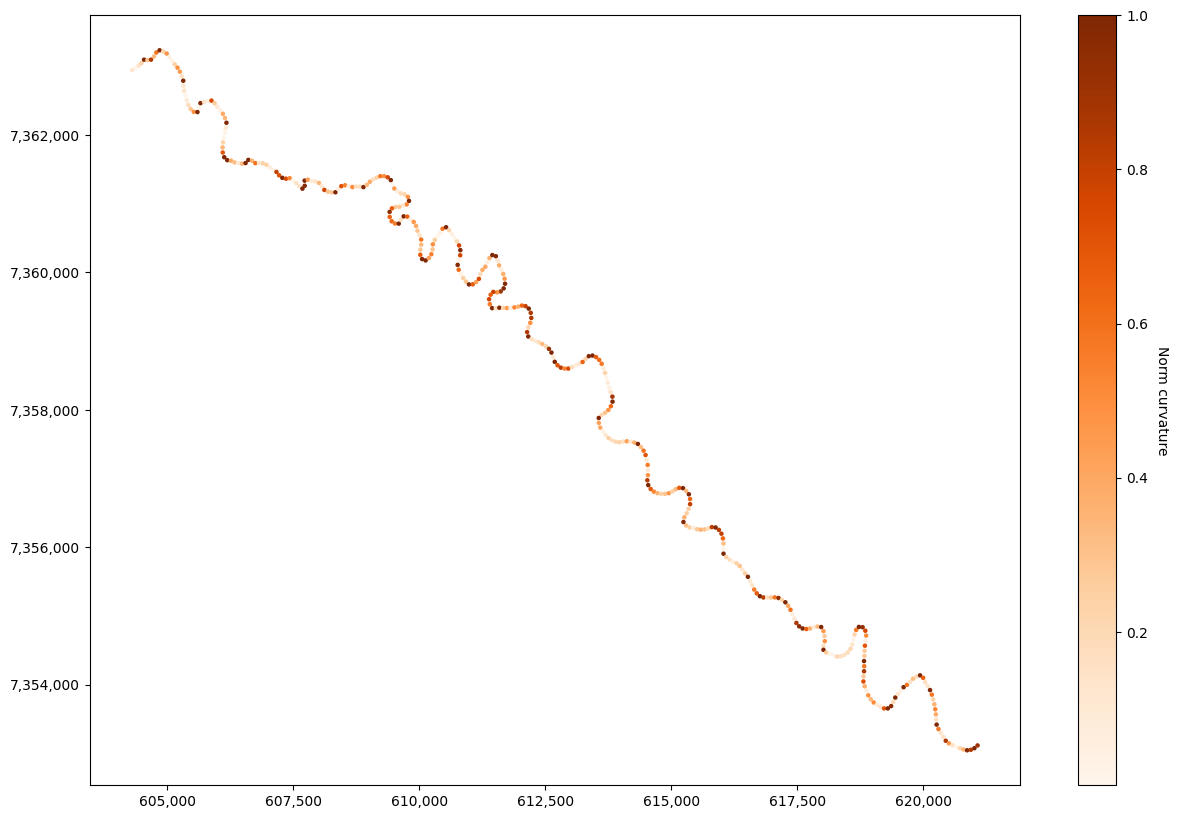

In [11]:
#NORMALISOITU KAAREVUUS k(x_i,j)/K_M_j


def define_normalized_curvature(points):
    points['norm_curvature'] = None

    for i in range(max(points['halfmeander'])+1): 

            pm = (points['halfmeander'] == i)
            filtered_pm = points[pm]

            maxcurvature = filtered_pm['curvature'].max()

            # Iterate through the index of filtered_pm
            for index in filtered_pm.index:
                # Use loc to set values in the original dataframe
                points.loc[index, 'norm_curvature'] = filtered_pm.loc[index, 'curvature'] / maxcurvature

define_normalized_curvature(pisteet100)

print(pisteet100)



fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(
    pisteet100.geometry.x,
    pisteet100.geometry.y,
    c=pisteet100['norm_curvature'],
    cmap='Oranges',
    s=5
)

    # Lisää värikartan selitys
cbar = plt.colorbar(scatter, label='Norm curvature')
cbar.set_label('Norm curvature', rotation=270, labelpad=15)

    # x ja y akselit
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
    return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

plt.show()
                  

     Id  gridcode    Shape_Leng    Shape_Area   
0  5126         1  86290.411758  1.443594e+07  \

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

<Axes: >

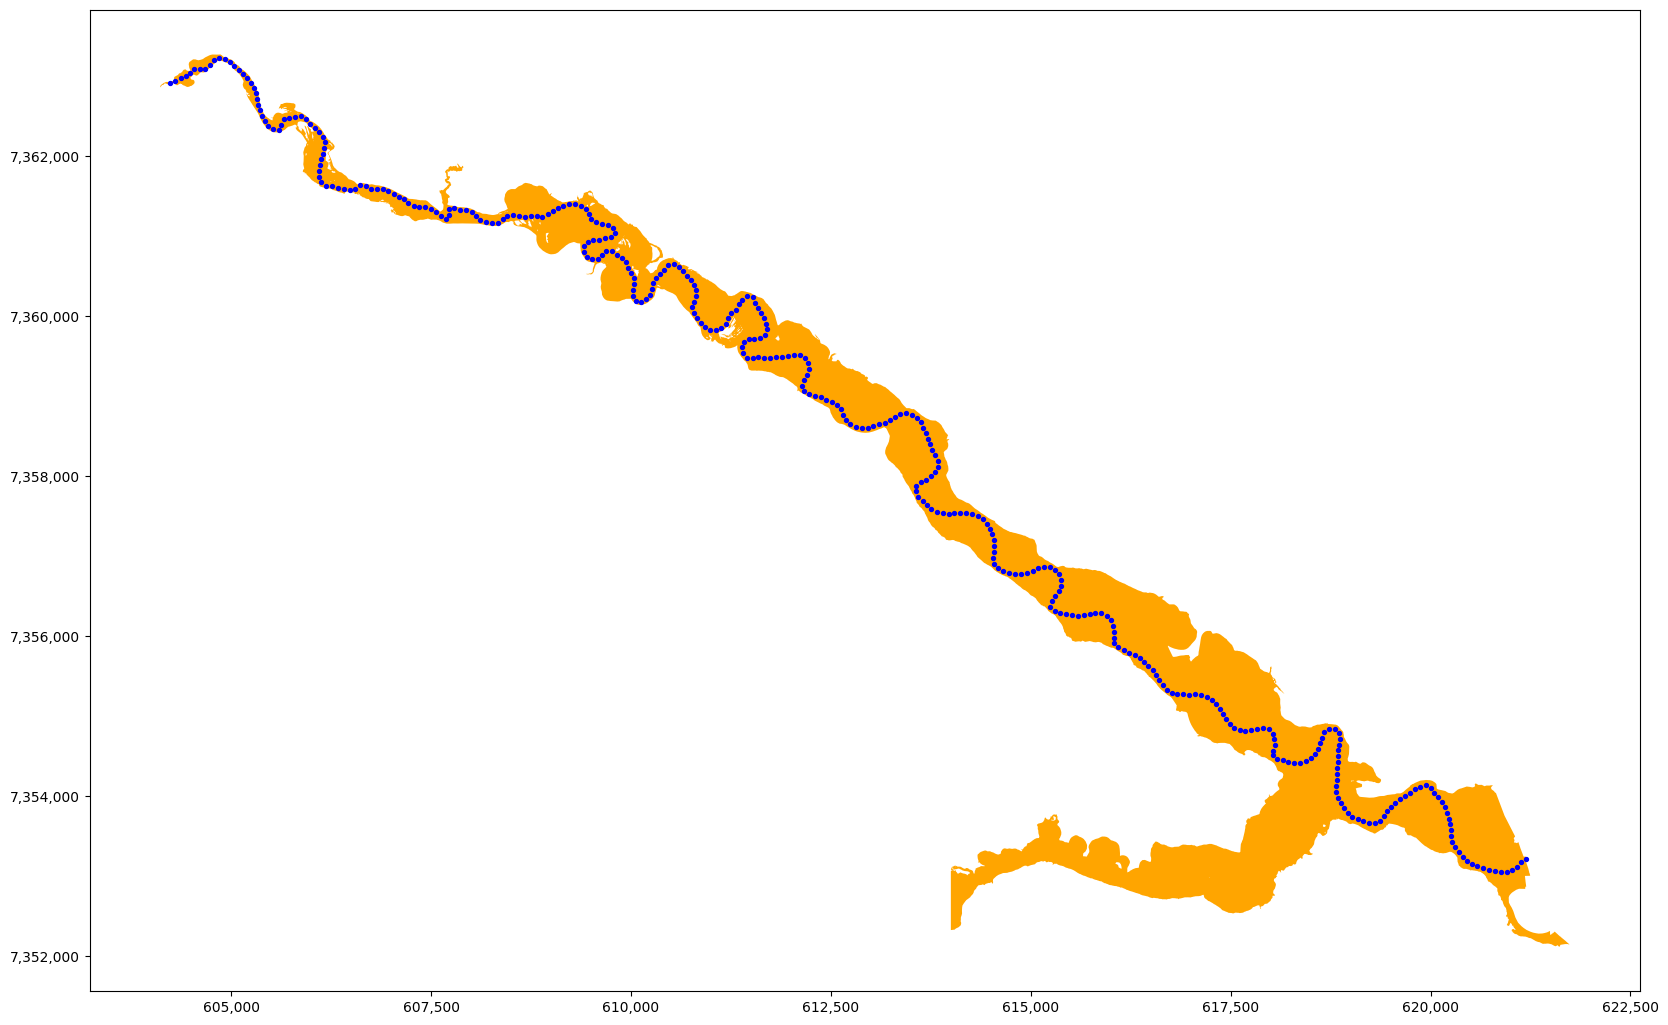

In [12]:
import geopandas as gpd
from shapely.geometry import Point

# Lataa sallittu alue shapefilena
sallittu_alue = gpd.read_file(r'C:\Users\oonao\Documents\lipasto\5_vuosi\gradu\gis\sallittualue.shp')

print(sallittu_alue)


for i in range(len(pisteet100)):
    # Tarkista, onko jokisijainti sallitulla alueella
    if pisteet100['geometry'].iloc[i].within(sallittu_alue.geometry.iloc[0]):
        print("Pisteen sijainti on sallitulla alueella.", pisteet100['geometry'].iloc[i])
    else:
        print("Pisteen sijainti ei ole sallitulla alueella.")

 #kuvakoko
fig, ax = plt.subplots(figsize=(20, 15))

    # x ja y akselit
def format_eastings(value, pos):
    return f'{int(value):,}'

def format_northings(value, pos):
        return f'{int(value):,}'

ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
ax.yaxis.set_major_formatter(FuncFormatter(format_northings))

sallittu_alue.plot(ax=ax, color = 'orange')

pisteet100.plot(ax=ax, color='blue', marker='o', markersize=8, label='points p_i')

In [13]:
def check_feasible_region(edellinen, point, feasibleregion):

    # Tarkista, onko piste sallitulla alueella

    #Jos on alueella niin uusi piste on 
    if Point(point).within(feasibleregion.geometry.iloc[0]):
        new_p = Point(point)
    else:
        new_p = edellinen

    return new_p
    

In [14]:
#MÄÄRITTELEE SUUNNAT D JA L
import math


def define_directions(inflectionpoints):
    D_list = []
    L_list = []
    
    for i in range(len(inflectionpoints) - 1):
        x1, y1 = inflectionpoints[i].x, inflectionpoints[i].y
        x2, y2 = inflectionpoints[i + 1].x, inflectionpoints[i + 1].y

        # Calculate direction vector v
        v = (x2 - x1, y2 - y1)

        # Calculate the length of the vector v
        v_length = math.sqrt(v[0] ** 2 + v[1] ** 2) 

        # Normalize direction vector
        # Parallel direction D
        D = (v[0] / v_length, v[1] / v_length)

        # Perpendicular direction L
        L = (- D[1], D[0])

        D_list.append(D)
        L_list.append(L)

    return D_list, L_list

D100, L100 = define_directions(kaannepisteet100)
print("D:", D100)
print("L:", L100)



D: [(0.8667653983113366, 0.4987160958804017), (0.999632080538726, -0.027123855880351155), (0.6046527067083761, -0.7964892367573051), (0.6218391495351346, -0.7831449879207684), (0.9785470270532453, 0.20602358079903194), (0.35115446663423666, -0.9363175425905598), (0.1917335493889077, -0.9814470164194965), (0.9932803490919435, -0.11573308994313843), (0.9981524967869178, -0.06075848219007887), (0.8871658369662346, -0.46145073162798245), (0.9636276325186616, -0.2672485469492384), (0.9998285255534395, -0.01851808547434352), (0.9999961670956535, 0.00276871703177023), (0.9987848196781102, 0.04928370907881352), (0.9897158129901059, 0.1430475778100894), (0.6633717820700687, -0.7482899696997022), (-0.4889151754823132, -0.8723313310795955), (0.995190717073035, -0.09795629970378905), (0.6916463802190139, -0.7222363080944736), (0.8592150985095985, 0.5116145174769192), (0.4678014705589741, -0.8838335726497729), (0.7347396687178532, -0.6783491867853748), (0.8147619396361507, 0.5797956378935061), (-0.

In [15]:
#Malli
#LIIKKUMISARVOT metreinä

def offsets(points, OD, OL, sD, sL, w):
    od_xi = []
    ol_xi = []

    max_curvature=points['curvature'].max()

    for i in range(len(points)):
            
        if w > 0:
            OD_xi = OD - (sD * (points['curvature'].iloc[i] / max_curvature))

            OL_xi = OL - (sL * (1 - (points['curvature'].iloc[i] / max_curvature)))


        elif w < 0:
            OD_xi = OD - (sD * (1 - (points['curvature'].iloc[i] / max_curvature)))

            OL_xi = OL - (sL * (points['curvature'].iloc[i] / max_curvature))

        #probability distribution accepting negative offsets of lateral and downstream migration
        #od_xi.append(OD_xi)
        #ol_xi.append(OL_xi)

        #probability distribution not accepting negative offsets of lateral and downstream migration
        od_xi.append(np.abs(OD_xi))
        ol_xi.append(np.abs(OL_xi))

    return od_xi, ol_xi


C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.4041319004897346, 0.9147007199114665)
L-suunta:  (0.16706576543969406, 0.9859457540950461)
L-suunta:  (0.7888150289173815, 0.6146306615798391)
L-suunta:  (-0.03504682352772973, 0.9993856713804817)
L-suunta:  (0.9578343858483133, 0.28732088209279993)
L-suunta:  (0.9250979751749493, 0.3797285034431954)
L-suunta:  (0.0025576298301197824, 0.9999967292594771)
L-suunta:  (0.2949566598344096, 0.9555106324993607)
L-suunta:  (0.39147366000077405, 0.9201893139596864)
L-suunta:  (-0.1074892260655016, 0.9942062493667195)
L-suunta:  (0.3315649201837805, 0.9434324054766846)
L-suunta:  (-0.16808679417206096, 0.9857721996612397)
L-suunta:  (-0.15062283827058331, 0.9885913010902502)
L-suunta:  (0.7482899696997022, 0.6633717820700687)
L-suunta:  (0.8723313310795955, -0.4889151754823132)
L-suunta:  (0.09795629970378905, 0.995190717073035)
L-suunta:  (0.7222363080944736, 0.6916463802190139)
L-suunta:  (-0.5116145174769192, 0.8592150985095985)
L-suunta:  (0.9676411039174163, 0.25233052532241

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (0.13077500863335878, -0.9914120723074462)
L-suunta:  (-0.6660661674431948, -0.7458926602317077)
L-suunta:  (-0.3378938658018571, -0.941184219721876)
L-suunta:  (-0.49181733320724774, -0.8706984040165177)
L-suunta:  (-0.9971327025870093, 0.07567280509883897)
L-suunta:  (-0.653481556210451, -0.7569424388239618)
L-suunta:  (0.28757705396202166, -0.9577575048176467)
L-suunta:  (-0.5585446431837668, -0.8294744610720204)
L-suunta:  (-0.5799851815001894, -0.8146270246193607)
L-suunta:  (-0.3218771522490869, -0.9467814419706472)
L-suunta:  (-0.7122736736962675, -0.7019018547911261)
L-suunta:  (-0.6963306353332337, -0.7177211480069507)
L-suunta:  (-0.3132382132599388, -0.9496745872948907)
L-suunta:  (-0.901972637126057, -0.4317931934107649)
L-suunta:  (-0.4294933061644682, -0.9030700415581919)
L-suunta:  (-0.7016254136220443, -0.7125459837510105)
L-suunta:  (-0.6272054183811212, -0.7788538779215026)
L-suunta:  (-0.9680097429354664, 0.25091260945200106)
L-suunta:  (-0.625375185507781

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.4083058744529261, 0.9128451746529809)
L-suunta:  (0.1230323438678267, 0.9924026614043256)
L-suunta:  (0.8131677054875102, 0.5820294517910395)
L-suunta:  (0.5323513976339295, 0.8465234724667722)
L-suunta:  (0.712872921013062, 0.7012932328821551)
L-suunta:  (0.220445626338376, 0.9753992648286552)
L-suunta:  (0.29190233478461436, 0.9564481308190689)
L-suunta:  (0.11429482599740277, 0.9934468746491799)
L-suunta:  (-0.15903861587712015, 0.9872723629576035)
L-suunta:  (-0.15099361254480942, 0.9885347383732491)
L-suunta:  (0.8749183497205156, 0.48427046298770865)
L-suunta:  (0.9704883962247535, -0.24114782352968864)
L-suunta:  (0.14094135503796038, 0.9900179465242354)
L-suunta:  (0.7668143461483223, 0.6418689574524702)
L-suunta:  (0.17603623618398298, 0.9843836871617576)
L-suunta:  (0.6043993796889063, 0.7966814858095205)
L-suunta:  (-0.5563189208035622, 0.8309688672603565)
L-suunta:  (0.9969198225947911, 0.07842746532669609)
L-suunta:  (0.9553169510596248, -0.2955833605231228)

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (0.13982128909132488, -0.990176755492089)
L-suunta:  (-0.6694957303616992, -0.7428159038600716)
L-suunta:  (-0.3225360604999975, -0.9465571771832604)
L-suunta:  (-0.5349246419047315, -0.8448997736318165)
L-suunta:  (-0.9528928896616035, -0.3033070075556435)
L-suunta:  (0.21609549303090925, -0.9763722332654325)
L-suunta:  (-0.5617887206478722, -0.8272807463931618)
L-suunta:  (-0.522758805358746, -0.8524806340439042)
L-suunta:  (-0.4076982061135484, -0.9131167355446917)
L-suunta:  (-0.711997952497418, -0.7021815403722063)
L-suunta:  (-0.6452955718972545, -0.763932997644293)
L-suunta:  (-0.48541759458452255, -0.8742824251166073)
L-suunta:  (-0.8356408845782203, -0.5492761709935446)
L-suunta:  (-0.34688812732027313, -0.9379065129980887)
L-suunta:  (-0.7294579920110547, -0.6840256120140532)
L-suunta:  (-0.6635316725586167, -0.7481481935496235)
L-suunta:  (-0.9696339617355729, 0.24456079049794077)
L-suunta:  (-0.699381964523059, -0.7147481148627581)
L-suunta:  (0.11502046687835518

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.40790288181520057, 0.9130253222155749)
L-suunta:  (0.055854125540083, 0.9984389398757204)
L-suunta:  (0.7861933241368544, 0.6179806284040325)
L-suunta:  (0.6457855391119229, 0.7635188520749983)
L-suunta:  (0.6848620107213421, 0.7286727840881121)
L-suunta:  (0.19286375204921832, 0.9812255465210319)
L-suunta:  (0.4060508674065664, 0.9138504763244231)
L-suunta:  (0.10593190784778984, 0.9943733860576355)
L-suunta:  (-0.010668392030246087, 0.9999430910864324)
L-suunta:  (-0.10857441686095515, 0.9940883240453554)
L-suunta:  (0.8307844873743484, 0.5565942288041991)
L-suunta:  (0.986749767328829, -0.16224948898687472)
L-suunta:  (0.6609909793769169, 0.7503938467114081)
L-suunta:  (0.1676564413159141, 0.9858454836764651)
L-suunta:  (0.3412738021502874, 0.9399639312047493)
L-suunta:  (0.5158142896425641, 0.8567004252365799)
L-suunta:  (-0.42891889233058467, 0.9033430045126293)
L-suunta:  (0.9994399630360058, 0.03346281946559714)
L-suunta:  (0.6257383604364903, 0.7800330148642767)


C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (0.21753741083677702, -0.9760519837008843)
L-suunta:  (-0.6064741375799189, -0.795103213706682)
L-suunta:  (-0.47350780455767305, -0.8807896224541776)
L-suunta:  (-0.4462520294840722, -0.8949073282644113)
L-suunta:  (-0.9656317228271152, -0.259914170198428)
L-suunta:  (0.14593701025533398, -0.9892938840596027)
L-suunta:  (-0.5032816539488019, -0.8641224316024659)
L-suunta:  (-0.5295296579898473, -0.8482914247528118)
L-suunta:  (-0.41895776047157485, -0.9080057240682144)
L-suunta:  (-0.6966405741691377, -0.717420316426357)
L-suunta:  (-0.6358058115870437, -0.7718490590472601)
L-suunta:  (-0.5861718936693204, -0.8101867137099465)
L-suunta:  (-0.698979124650642, -0.7151420721105857)
L-suunta:  (-0.39576006716506495, -0.918353945512025)
L-suunta:  (-0.733113206297499, -0.6801066289576956)
L-suunta:  (-0.6868947466728562, -0.7267569105232042)
L-suunta:  (-0.9822874332358719, 0.18738035784703375)
L-suunta:  (-0.6226302790693069, -0.7825161567572116)
L-suunta:  (0.03599436026278902

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.4138668949434472, 0.9103374062785016)
L-suunta:  (0.35320988758080807, 0.9355441065578644)
L-suunta:  (0.7848709229145772, 0.6196592889348307)
L-suunta:  (0.5965004740356593, 0.802612723843345)
L-suunta:  (0.7079970450470319, 0.706215395049323)
L-suunta:  (0.18448958803540821, 0.9828344682124887)
L-suunta:  (0.2986003476234292, 0.9543782438840311)
L-suunta:  (0.14591069681415159, 0.9892977653645079)
L-suunta:  (-0.16527060091744641, 0.9862482590465679)
L-suunta:  (-0.02484559724993332, 0.9996913005009567)
L-suunta:  (0.8501827267574286, 0.5264877312182151)
L-suunta:  (0.9788645763009112, -0.20450951386974123)
L-suunta:  (0.6743941795984083, 0.7383715125353834)
L-suunta:  (-0.16903371539356774, 0.9856102693561215)
L-suunta:  (0.1956805417466324, 0.9806676937585659)
L-suunta:  (0.6792633515318678, 0.7338946104623566)
L-suunta:  (-0.5763827131038088, 0.8171798871944246)
L-suunta:  (0.9948807244758366, 0.10105614314050622)
L-suunta:  (0.6183257070328421, 0.7859219554270868)


C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (0.059136298513910425, -0.9982499177050173)
L-suunta:  (-0.7073696691159866, -0.7068437954843627)
L-suunta:  (-0.36671523591239175, -0.9303332390867903)
L-suunta:  (-0.5149914482984894, -0.857195315070856)
L-suunta:  (-0.9535089827267168, -0.301364596227662)
L-suunta:  (0.16731418219012456, -0.9859036283724945)
L-suunta:  (-0.6099178906993937, -0.7924646153644985)
L-suunta:  (-0.5184936902845184, -0.8550814540937851)
L-suunta:  (-0.3660863460680957, -0.9305808869853873)
L-suunta:  (-0.7094816274859186, -0.704723931947775)
L-suunta:  (-0.6963173481142586, -0.7177340389831922)
L-suunta:  (-0.48109635775399057, -0.8766677218626475)
L-suunta:  (-0.7898598916305481, -0.6132873320013865)
L-suunta:  (-0.2710146149209228, -0.962575232643799)
L-suunta:  (-0.7407571689137293, -0.6717728907174781)
L-suunta:  (-0.7574970061600667, -0.6528386367690991)
L-suunta:  (-0.9820010473075622, 0.18887546978591693)
L-suunta:  (-0.6354832968858325, -0.7721146154419773)
L-suunta:  (0.060977682339616

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.3976166874398289, 0.9175516170054835)
L-suunta:  (0.5042311484624032, 0.8635687285446861)
L-suunta:  (0.7427552945871109, 0.6695629711706094)
L-suunta:  (0.7030437689117894, 0.7111465805263402)
L-suunta:  (0.6945283055407404, 0.7194653798500024)
L-suunta:  (0.13947224345501572, 0.9902259809284065)
L-suunta:  (0.3345804273514333, 0.9423671989375119)
L-suunta:  (0.12603137733264877, 0.9920262556644533)
L-suunta:  (-0.15412422874232168, 0.9880514774618702)
L-suunta:  (-0.17432634189865143, 0.9846879335709534)
L-suunta:  (0.7373741948414138, 0.6754844904081638)
L-suunta:  (0.9780504178491298, -0.20836837606782477)
L-suunta:  (0.6851016369678637, 0.7284474909174672)
L-suunta:  (-0.09752399141506625, 0.9952331742353016)
L-suunta:  (0.2807973364008806, 0.9597670841772866)
L-suunta:  (0.573008097036788, 0.8195497060766227)
L-suunta:  (-0.5776154581871376, 0.8163089993766228)
L-suunta:  (0.9981984134545627, 0.05999939480356208)
L-suunta:  (0.5034744866083068, 0.8640100933059184)


C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.3848367101719127, -0.9229846729518639)
L-suunta:  (-0.47765889395514755, -0.8785453778977754)
L-suunta:  (-0.3920826271599442, -0.9199300046630483)
L-suunta:  (-0.9571437384956842, -0.2896133005552494)
L-suunta:  (0.19181421638391608, -0.9814312540331208)
L-suunta:  (-0.6201077786890413, -0.7845166300400158)
L-suunta:  (-0.5109000236820576, -0.8596401373840528)
L-suunta:  (-0.3758267569258652, -0.9266899420942188)
L-suunta:  (-0.7113950354819991, -0.7027923615774185)
L-suunta:  (-0.6756713894325994, -0.7372029391573399)
L-suunta:  (-0.4525283410487067, -0.8917500213331678)
L-suunta:  (-0.9361314116492899, -0.3516503663065172)
L-suunta:  (-0.29385726867801826, -0.9558493111600255)
L-suunta:  (-0.730274905460557, -0.6831533959913942)
L-suunta:  (-0.7094059432994742, -0.704800118907044)
L-suunta:  (-0.8841235882562344, -0.467253122717142)
L-suunta:  (-0.06336522949728624, -0.9979904046085596)
L-suunta:  (-0.7114880959426576, -0.7026981495150615)
L-suunta:  (-0.4666469073687

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.4007978932057887, 0.9161664962231488)
L-suunta:  (0.5150098736711067, 0.8571842450846087)
L-suunta:  (0.7390611741346577, 0.6736383160767366)
L-suunta:  (0.6686168471094976, 0.7436070950181652)
L-suunta:  (0.6893562582673781, 0.7244224935682216)
L-suunta:  (0.1630573367999298, 0.9866165946889979)
L-suunta:  (0.3146957709114885, 0.9491925893992347)
L-suunta:  (0.12786368008089605, 0.9917917519903915)
L-suunta:  (-0.16468765079825395, 0.9863457698365987)
L-suunta:  (-0.0029609554285248093, 0.999995616361867)
L-suunta:  (0.8566207129068768, 0.5159466583077307)
L-suunta:  (0.9654874661149647, -0.2604495205887408)
L-suunta:  (0.5283979762442043, 0.8489968072384191)
L-suunta:  (0.44948392542685506, 0.8932884197071321)
L-suunta:  (0.005982570116530296, 0.9999821042672719)
L-suunta:  (0.5969633783154519, 0.8022684868235836)
L-suunta:  (-0.32753797189181194, 0.9448380162594001)
L-suunta:  (0.9999831356317086, -0.005807620181792057)
L-suunta:  (0.6882357704201514, 0.72548709451938

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.3646731563638754, -0.9311355911077659)
L-suunta:  (-0.79356862917471, -0.6084807563019324)
L-suunta:  (0.5570896293215819, -0.8304523736508568)
L-suunta:  (-0.48991611283834535, -0.8717695810140232)
L-suunta:  (-0.9733102918094546, -0.22949308455331419)
L-suunta:  (0.2512668617962251, -0.9679178499041522)
L-suunta:  (-0.6564083583793819, -0.7544057708220987)
L-suunta:  (-0.5022501363816685, -0.864722383487669)
L-suunta:  (-0.3672941567441064, -0.9301048341029283)
L-suunta:  (-0.7107659609663345, -0.7034285669004373)
L-suunta:  (-0.6725456021378569, -0.7400556823949315)
L-suunta:  (-0.5077827060052332, -0.8614851847141674)
L-suunta:  (-0.7882693070572245, -0.615330398689617)
L-suunta:  (-0.28580693435657384, -0.9582872201348075)
L-suunta:  (-0.7855360034008761, -0.6188159559683144)
L-suunta:  (-0.7151393194372844, -0.6989819409646987)
L-suunta:  (-0.8765205440348327, -0.48136445224474256)
L-suunta:  (-0.030006448600609463, -0.9995497051384583)
L-suunta:  (-0.7535421614582

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.40505192647549354, 0.914293681952627)
L-suunta:  (0.6039332680238241, 0.7970348849166289)
L-suunta:  (0.729881266414634, 0.6835739440155469)
L-suunta:  (0.6269827583395299, 0.7790331319943682)
L-suunta:  (0.7138779773160656, 0.7002701146722761)
L-suunta:  (0.1691749947411738, 0.9855860293015135)
L-suunta:  (0.30424549524161204, 0.9525936587156069)
L-suunta:  (0.1283058871380265, 0.9917346415880227)
L-suunta:  (-0.16487925366406528, 0.9863137592628325)
L-suunta:  (0.009579998969571483, 0.9999541107569603)
L-suunta:  (0.9121117950514047, 0.4099415486726178)
L-suunta:  (0.7593020834121519, 0.6507383084819623)
L-suunta:  (0.4471919485389472, 0.8944380141529873)
L-suunta:  (0.3137171971870801, 0.9495164665181342)
L-suunta:  (0.35418216981645007, 0.9351764489036877)
L-suunta:  (0.4996057073606477, 0.8662529290990402)
L-suunta:  (0.8996498688936573, 0.43661208572327165)
L-suunta:  (0.2553665204972887, 0.9668443205651609)
L-suunta:  (0.8951064488906958, 0.445852492596249)
L-suun

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.32501993217703185, -0.9457071659280359)
L-suunta:  (-0.7776253953800076, -0.6287278779091052)
L-suunta:  (0.5778072333109341, -0.816173266612895)
L-suunta:  (-0.4972059971341697, -0.8676325238335731)
L-suunta:  (-0.9803579022687947, -0.19722673109679714)
L-suunta:  (0.32622976677765825, -0.9452905052248196)
L-suunta:  (-0.6812559912140413, -0.7320452680230739)
L-suunta:  (-0.47936405671964255, -0.8776161468006883)
L-suunta:  (-0.481720914241675, -0.876324689131925)
L-suunta:  (-0.6904302660183588, -0.7233989547724122)
L-suunta:  (-0.6719492331104937, -0.7405972104472305)
L-suunta:  (-0.632476728900401, -0.7745793615888875)
L-suunta:  (-0.6074812360075379, -0.794334027911907)
L-suunta:  (-0.3668768111745905, -0.9302695337494203)
L-suunta:  (-0.7343570307027891, -0.6787633987313862)
L-suunta:  (-0.7103124240885138, -0.7038865392842083)
L-suunta:  (-0.8657105054530962, -0.5005450236973139)
L-suunta:  (-0.05196049957185772, -0.9986491408318755)
L-suunta:  (-0.737152007402563

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.40220603362086105, 0.9155491830147493)
L-suunta:  (0.5033621431326917, 0.8640755481211486)
L-suunta:  (0.7334254826990542, 0.6797698590903097)
L-suunta:  (0.639886654161934, 0.7684693031120017)
L-suunta:  (0.6785810277098886, 0.7345255535597052)
L-suunta:  (0.15480265800595766, 0.9879454119911133)
L-suunta:  (0.3028658623129295, 0.9530331943040838)
L-suunta:  (0.11930700788375667, 0.9928574106435553)
L-suunta:  (-0.1700466932822004, 0.9854360060926277)
L-suunta:  (-0.041128626308849475, 0.9991538600725851)
L-suunta:  (0.8522821780191233, 0.5230822966140025)
L-suunta:  (0.7852483517661473, 0.6191809315931402)
L-suunta:  (0.1355229132320433, 0.99077421241628)
L-suunta:  (0.6726000625553796, 0.7400061863596139)
L-suunta:  (0.3627398777384612, 0.9318904340630857)
L-suunta:  (0.9097034807123439, 0.41525844624745)
L-suunta:  (0.4435941662871737, 0.8962277699535912)
L-suunta:  (0.7250251641891136, 0.688722376064949)
L-suunta:  (0.2031339342760791, 0.9791509611625379)
L-suunta: 

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.31712902462017134, -0.948382402696011)
L-suunta:  (-0.5679141957005852, -0.8230877634382361)
L-suunta:  (-0.3010102690266161, -0.9536208984394816)
L-suunta:  (-0.9560992865113047, -0.2930429223383056)
L-suunta:  (0.20208522038070187, -0.9793679409209203)
L-suunta:  (-0.633802097993588, -0.773495249228414)
L-suunta:  (-0.5065787472152602, -0.8621936979993635)
L-suunta:  (-0.40378920549019526, -0.9148520522628765)
L-suunta:  (-0.6904807742129786, -0.7233507451038159)
L-suunta:  (-0.7048939480990892, -0.7093127109627168)
L-suunta:  (-0.4550319047242681, -0.8904751347920978)
L-suunta:  (-0.798654877277271, -0.6017893211093291)
L-suunta:  (-0.30284009759953623, -0.9530413817279412)
L-suunta:  (-0.7632043825913382, -0.6461571561109375)
L-suunta:  (-0.6883538381564799, -0.7253750709083147)
L-suunta:  (-0.901280207905349, -0.4332366406920022)
L-suunta:  (-0.020686629081482364, -0.9997860087925042)
L-suunta:  (-0.6590942942744495, -0.7520603109158637)
L-suunta:  (-0.7427172368172

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.41347502265919395, 0.9105154615035261)
L-suunta:  (0.4941088534957829, 0.8694000465246612)
L-suunta:  (0.7231470708415672, 0.690694081293058)
L-suunta:  (0.6030901597746565, 0.7976730277394236)
L-suunta:  (0.7119290156744255, 0.7022514340610801)
L-suunta:  (0.1665003915057584, 0.9860413883952484)
L-suunta:  (0.3253276910037355, 0.9456013396068018)
L-suunta:  (0.12562855723663072, 0.992077348600724)
L-suunta:  (-0.17878785017588394, 0.9838876483773367)
L-suunta:  (0.04220606767904645, 0.9991089269199188)
L-suunta:  (0.9174797809293233, 0.3977824173915698)
L-suunta:  (0.720428779734817, 0.6935289275364097)
L-suunta:  (0.4892310985121736, 0.8721541906386577)
L-suunta:  (0.14784363410603302, 0.9890107480984832)
L-suunta:  (0.5376008590102168, 0.8431994523192463)
L-suunta:  (0.5109456857436278, 0.8596129979356838)
L-suunta:  (0.8559177122579981, 0.517112047667655)
L-suunta:  (0.44111959581576976, 0.8974483284219387)
L-suunta:  (0.7258858063816264, 0.6878152339790797)
L-suunta

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.3479024119376057, -0.9375307524385514)
L-suunta:  (-0.5213922917998367, -0.8533171028707405)
L-suunta:  (-0.3414946209575243, -0.9398837289032493)
L-suunta:  (-0.9391359239740691, -0.34354579942326674)
L-suunta:  (0.12142225295149749, -0.9926009452384088)
L-suunta:  (-0.5189417923840751, -0.8548095788637393)
L-suunta:  (-0.5194577759028872, -0.8544961199759926)
L-suunta:  (-0.4766179901605894, -0.8791105115144968)
L-suunta:  (-0.6979662481784016, -0.7161306559586496)
L-suunta:  (-0.6425963670465458, -0.7662048740764974)
L-suunta:  (-0.5845991159557877, -0.8113222994739583)
L-suunta:  (-0.7548451894340337, -0.6559029958677562)
L-suunta:  (-0.39277775259983605, -0.9196334253726437)
L-suunta:  (-0.7275801673669698, -0.6860226673035317)
L-suunta:  (-0.6913217393867587, -0.7225470591257476)
L-suunta:  (-0.8563922919973355, -0.5163257132930243)
L-suunta:  (-0.09214651536831996, -0.9957454592944303)
L-suunta:  (-0.6744495919767585, -0.7383208976335317)
L-suunta:  (-0.6891765102

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.42045714648650334, 0.9073123982225896)
L-suunta:  (0.5077793548876014, 0.8614871599449009)
L-suunta:  (0.6957640987751006, 0.7182703661266223)
L-suunta:  (0.5944023187137573, 0.8041678204875579)
L-suunta:  (0.7721039523953562, 0.6354962523063921)
L-suunta:  (0.17305821303466026, 0.9849115975057103)
L-suunta:  (0.32002833753917936, 0.9474079708192817)
L-suunta:  (0.10535575858952335, 0.9944345952007231)
L-suunta:  (-0.14482451656156578, 0.9894573560304196)
L-suunta:  (-0.05637065843976957, 0.9984099102408123)
L-suunta:  (0.9004476893038846, 0.4349643190277736)
L-suunta:  (0.7422017130929753, 0.670176556648957)
L-suunta:  (0.21742507592852506, 0.9760770135381096)
L-suunta:  (0.23088721591963726, 0.972980520629719)
L-suunta:  (0.43563017246630165, 0.9001257427920726)
L-suunta:  (0.6560219254475431, 0.7547418322394076)
L-suunta:  (0.8408569372129084, 0.5412574351830438)
L-suunta:  (0.4727002036400814, 0.8812233073850382)
L-suunta:  (0.7203928769728787, 0.6935662209239567)
L-

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.3376878215956387, -0.941258166044785)
L-suunta:  (-0.6647207759843288, -0.7470918885751551)
L-suunta:  (-0.2925260350609878, -0.9562575588258102)
L-suunta:  (-0.9622964943031266, -0.2720026783910639)
L-suunta:  (0.30452152977435326, -0.9525054529523113)
L-suunta:  (-0.6383577987766663, -0.7697397746907777)
L-suunta:  (-0.47616766779606146, -0.8793545087993009)
L-suunta:  (-0.48912534229803667, -0.8722135056979045)
L-suunta:  (-0.6981677995077931, -0.7159341615892105)
L-suunta:  (-0.6410521897577687, -0.7674972899019056)
L-suunta:  (-0.49979036617550404, -0.8661464021042606)
L-suunta:  (-0.7732960471327501, -0.6340451273283814)
L-suunta:  (-0.45607933449695387, -0.8899391218756569)
L-suunta:  (-0.6865268931632434, -0.7271044113218023)
L-suunta:  (-0.6699782928266307, -0.7423806888255605)
L-suunta:  (-0.8864346805688395, -0.4628537102420371)
L-suunta:  (-0.12133330459180428, -0.9926118220114207)
L-suunta:  (-0.665255369807772, -0.7466158938449707)
L-suunta:  (-0.7027452429

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.42178879711539174, 0.9066941108378013)
L-suunta:  (0.3671051640488119, 0.9301794442626083)
L-suunta:  (0.6707744636763351, 0.7416613909862944)
L-suunta:  (0.5952731308115992, 0.8035234282419877)
L-suunta:  (0.7545430109415707, 0.6562505959153321)
L-suunta:  (0.18114084100803138, 0.9834571651673004)
L-suunta:  (0.33472483210658643, 0.9423159166496221)
L-suunta:  (0.09342303718147793, 0.995626504329705)
L-suunta:  (-0.18190545295744923, 0.9833160255911346)
L-suunta:  (0.07697488712913682, 0.997033031925952)
L-suunta:  (0.8922719030958486, 0.4514984506570456)
L-suunta:  (0.5070653619827472, 0.8619076044897768)
L-suunta:  (0.3212342281655789, 0.9469997733129955)
L-suunta:  (0.46563213132919373, 0.8849783716418342)
L-suunta:  (0.5407670667236422, 0.8411723839660382)
L-suunta:  (0.8853299282368099, 0.464963351424825)
L-suunta:  (0.35192354847686347, 0.9360287474364517)
L-suunta:  (0.8134342673112338, 0.5816568513856225)
L-suunta:  (0.33933119594651884, 0.9406669652206913)
L-su

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.3513412679388758, -0.9362474637846039)
L-suunta:  (-0.6950253994432347, -0.7189851835252045)
L-suunta:  (-0.4185236403582212, -0.9082059031196077)
L-suunta:  (-0.811147846030852, -0.5848411509799127)
L-suunta:  (0.20357657485898017, -0.9790590269073086)
L-suunta:  (-0.5412125419383588, -0.8408858331834472)
L-suunta:  (-0.49266537046899683, -0.8702188418671744)
L-suunta:  (-0.4697609607733717, -0.8827936563734918)
L-suunta:  (-0.7001100078798999, -0.7140349969479133)
L-suunta:  (-0.6481919391429465, -0.7614769924496122)
L-suunta:  (-0.499600858179275, -0.8662557258145727)
L-suunta:  (-0.7492651416720227, -0.6622701469001934)
L-suunta:  (-0.47207779860705107, -0.8815568909958792)
L-suunta:  (-0.6850838519959324, -0.7284642171956117)
L-suunta:  (-0.6901968813063425, -0.7236216311270681)
L-suunta:  (-0.8745782381459751, -0.48488442474622967)
L-suunta:  (-0.08348769633121299, -0.996508808070108)
L-suunta:  (-0.7218734641602231, -0.6920250730582808)
L-suunta:  (-0.556463411829

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (0.02755265519699848, 0.9996203535300766)
L-suunta:  (0.7101368541069016, 0.7040636678874669)
L-suunta:  (0.5854858540428733, 0.8106826226802244)
L-suunta:  (0.7548805525877171, 0.6558622960079828)
L-suunta:  (0.1781546661620715, 0.9840024974179085)
L-suunta:  (0.326031409385931, 0.9453589371735073)
L-suunta:  (0.09318994845338095, 0.995648348317445)
L-suunta:  (-0.19418040198082087, 0.9809658360445418)
L-suunta:  (0.08871722077119862, 0.9960568531658393)
L-suunta:  (0.9087547704142438, 0.4173305251828036)
L-suunta:  (0.5152456423193286, 0.8570425474099536)
L-suunta:  (0.22174688214153893, 0.975104261225694)
L-suunta:  (0.6014677497696537, 0.7988970809729056)
L-suunta:  (0.3447741340605298, 0.9386856750173679)
L-suunta:  (0.8749457311740966, 0.4842209903548435)
L-suunta:  (0.44989726950666153, 0.8930803137962735)
L-suunta:  (0.7219307677890872, 0.6919652928575676)
L-suunta:  (0.2505968396317366, 0.9680915369770494)
L-suunta:  (0.6607528595082611, 0.7506035296024501)
L-suunta

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.32346095075587794, -0.9462415195583544)
L-suunta:  (-0.736972288647926, -0.6759229584538744)
L-suunta:  (-0.8633732704853231, -0.5045657497407816)
L-suunta:  (0.3299917654471926, -0.9439838106329181)
L-suunta:  (-0.6619694224340624, -0.7495308424356625)
L-suunta:  (-0.4549968873899432, -0.8904930277466879)
L-suunta:  (-0.4949589320838843, -0.8689163685593572)
L-suunta:  (-0.47019341130193143, -0.8825634005374643)
L-suunta:  (-0.7060374717708781, -0.7081744759982436)
L-suunta:  (-0.6310942161385751, -0.7757061881643317)
L-suunta:  (-0.5159014189345803, -0.8566479591648408)
L-suunta:  (-0.8146546411418274, -0.5799463903380039)
L-suunta:  (-0.47175905781760163, -0.8817275040323109)
L-suunta:  (-0.600234250699209, -0.7998242583765256)
L-suunta:  (-0.8733142451039849, -0.48715729420635456)
L-suunta:  (-0.799906080600901, -0.6001252054510833)
L-suunta:  (-0.1511876084231429, -0.9885050870174065)
L-suunta:  (-0.7070603682248149, -0.7071531911020337)
L-suunta:  (-0.6320821243222

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (0.17167769776764363, 0.9851531698620279)
L-suunta:  (0.6763555130043389, 0.7365753322156787)
L-suunta:  (0.6377933465295733, 0.7702075350985653)
L-suunta:  (0.6632668682571818, 0.7483829644455504)
L-suunta:  (0.15047976015617567, 0.9886130900323643)
L-suunta:  (0.3273458005599045, 0.9449046125698588)
L-suunta:  (0.09246209243871771, 0.9957162052823355)
L-suunta:  (-0.20875894200464193, 0.9779671283499781)
L-suunta:  (0.45905059608312615, 0.8884101250186911)
L-suunta:  (0.7974460846156778, 0.6033902071886197)
L-suunta:  (0.4139108635458346, 0.9103174155418216)
L-suunta:  (0.20695239130497392, 0.9783510145817568)
L-suunta:  (0.6016984176779511, 0.7987233652296958)
L-suunta:  (0.2381482016759791, 0.9712288268160584)
L-suunta:  (0.8895490180595254, 0.45683973608841677)
L-suunta:  (0.3536865000030665, 0.9353640252412858)
L-suunta:  (0.8269240700393989, 0.5623135979055417)
L-suunta:  (0.40872444754399495, 0.9126578362014189)
L-suunta:  (0.6547044663257463, 0.7558849527362744)
L-s

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.3591172958350081, -0.9332924342520684)
L-suunta:  (-0.23869001644238663, -0.9710958119829026)
L-suunta:  (-0.7673835725493039, -0.6411883128859004)
L-suunta:  (-0.8846377528252228, -0.4662789361276573)
L-suunta:  (0.4056499346922008, -0.914028517325479)
L-suunta:  (-0.6453328287633037, -0.7639015251459788)
L-suunta:  (-0.48792663947863857, -0.8728846398505834)
L-suunta:  (-0.5026347209443086, -0.8644988937536224)
L-suunta:  (-0.47102434774418767, -0.882120209400149)
L-suunta:  (-0.6976920793801901, -0.7163977682615618)
L-suunta:  (-0.6617913386260119, -0.7496880845522297)
L-suunta:  (-0.47276760697327885, -0.8811871479979491)
L-suunta:  (-0.7710636291515326, -0.6367581014794139)
L-suunta:  (-0.46566892437581203, -0.884959011972122)
L-suunta:  (-0.6380283722955218, -0.7700128545329145)
L-suunta:  (-0.8492724362454708, -0.52795485510949)
L-suunta:  (-0.810280940211354, -0.5860416349801472)
L-suunta:  (-0.1386228695248294, -0.9903452428545826)
L-suunta:  (-0.703154292157398

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.4248029221670153, 0.9052858539259104)
L-suunta:  (0.45474453992761504, 0.8906219194506847)
L-suunta:  (0.8010756010666511, 0.598563180771841)
L-suunta:  (0.5560734092788707, 0.8311331803585833)
L-suunta:  (0.7017205725405266, 0.7124522707335527)
L-suunta:  (0.13133924323154839, 0.9913374819844977)
L-suunta:  (0.32560882285496384, 0.9455045713686447)
L-suunta:  (0.09772202872518074, 0.9952137484489625)
L-suunta:  (-0.18206560563720406, 0.9832863851614941)
L-suunta:  (0.391166896903351, 0.9203197589789123)
L-suunta:  (0.7957101826279503, 0.6056775588233345)
L-suunta:  (0.2906179589588373, 0.9568391724478047)
L-suunta:  (0.19422024258240864, 0.9809579488292199)
L-suunta:  (0.5718852149099032, 0.820333652221737)
L-suunta:  (0.30947697617450437, 0.9509069361498449)
L-suunta:  (0.9099391012792685, 0.41474188595206685)
L-suunta:  (0.47845048184034417, 0.878114534913722)
L-suunta:  (0.7072454404060587, 0.7069680947714969)
L-suunta:  (0.3412357598351397, 0.9399777424012415)
L-suu

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.284680972382517, -0.9586223155984555)
L-suunta:  (-0.38975581111178265, -0.9209182415961779)
L-suunta:  (-0.7518495051207741, -0.6593347568948926)
L-suunta:  (-0.8777989161424523, -0.47902929223496976)
L-suunta:  (0.31362228776970197, -0.9495478190244545)
L-suunta:  (-0.6438009780748968, -0.7651929826062221)
L-suunta:  (-0.5008039612500005, -0.8655607387100618)
L-suunta:  (-0.4532687326648555, -0.8913739148014124)
L-suunta:  (-0.46600876698967125, -0.884780102109426)
L-suunta:  (-0.6953282392382689, -0.7186923122712588)
L-suunta:  (-0.6376824999731283, -0.7702993114549831)
L-suunta:  (-0.5905682239896145, -0.8069877154044865)
L-suunta:  (-0.7342174728316929, -0.678914355856939)
L-suunta:  (-0.4452767432141774, -0.8953929986059617)
L-suunta:  (-0.7763339152240597, -0.6303218638702632)
L-suunta:  (-0.6897451052889112, -0.7240522700261279)
L-suunta:  (-0.8636986085300937, -0.5040086443933077)
L-suunta:  (-0.08556042443491879, -0.9963329833798119)
L-suunta:  (-0.680248892239

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.4251721548623596, 0.9051125005929914)
L-suunta:  (0.517591321641343, 0.855627970417966)
L-suunta:  (0.5980660474564723, 0.8014468184975174)
L-suunta:  (0.7222806380458209, 0.6916000866860283)
L-suunta:  (0.6973853219817329, 0.7166963880782675)
L-suunta:  (0.1384150516492023, 0.9903743097823916)
L-suunta:  (0.31750325771100163, 0.9482571810130949)
L-suunta:  (0.09838209326477847, 0.995148714376319)
L-suunta:  (-0.17967066499561432, 0.9837268178412306)
L-suunta:  (0.3829998942535298, 0.9237483861971207)
L-suunta:  (0.7958020409419528, 0.6055568607757841)
L-suunta:  (0.5214733922596755, 0.8532675437195455)
L-suunta:  (0.16071980620862122, 0.9870000728937477)
L-suunta:  (0.6951745868558692, 0.7188409377531106)
L-suunta:  (0.18406654189503943, 0.9829137847007752)
L-suunta:  (0.8317363373619399, 0.5551708431750945)
L-suunta:  (0.4772464064042052, 0.8787695190288931)
L-suunta:  (0.7414858554693605, 0.6709684986188773)
L-suunta:  (0.30574689367647934, 0.952112827876604)
L-suunta

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.2589022016532955, -0.9659035407218861)
L-suunta:  (-0.6005367817922895, -0.7995971321325258)
L-suunta:  (-0.5321734272015681, -0.846635366247204)
L-suunta:  (-0.8784999949682243, -0.4777423561301948)
L-suunta:  (0.15677958982038837, -0.9876336163860313)
L-suunta:  (-0.550715591238972, -0.8346929600555582)
L-suunta:  (-0.4643944927378902, -0.88562845206933)
L-suunta:  (-0.705042101256572, -0.7091654499873199)
L-suunta:  (-0.6056738255862916, -0.7957130242742458)
L-suunta:  (-0.6421932532270803, -0.7665427747422965)
L-suunta:  (-0.6486316622905784, -0.761102467920162)
L-suunta:  (-0.351286594269804, -0.936267979099105)
L-suunta:  (-0.6861616080896809, -0.7274491374548349)
L-suunta:  (-0.8173753639106218, -0.5761054716559969)
L-suunta:  (-0.844630273202275, -0.5353500738677919)
L-suunta:  (-0.1236562952719693, -0.9923251083388003)
L-suunta:  (-0.6734175853665713, -0.7392623050846409)
L-suunta:  (-0.6680846608030337, -0.7440852679630846)
L-suunta:  (-0.6067188986755458, -0.7

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.4279301154246102, 0.9038118257207526)
L-suunta:  (0.4530412788270339, 0.891489539859423)
L-suunta:  (0.5791335680091779, 0.8152326725573252)
L-suunta:  (0.6733794653364302, 0.7392970280362444)
L-suunta:  (0.7878245655073061, 0.6158997109783577)
L-suunta:  (0.13817209115126677, 0.9904082356416903)
L-suunta:  (0.307744446658792, 0.951469051283684)
L-suunta:  (0.09293672665484928, 0.9956720166996167)
L-suunta:  (-0.196934292711742, 0.980416689145042)
L-suunta:  (0.40136192342379184, 0.915919541458503)
L-suunta:  (0.8295766137343542, 0.5583929100060657)
L-suunta:  (0.33475074691644785, 0.9423067109168225)
L-suunta:  (0.2480186237765851, 0.968755264377938)
L-suunta:  (0.692868260621583, 0.7210641950778183)
L-suunta:  (0.21523669660258318, 0.9765619101908529)
L-suunta:  (0.7936441439840144, 0.6083822587155884)
L-suunta:  (0.523786738510156, 0.8518494306864879)
L-suunta:  (0.7290238367696211, 0.6844883091928603)
L-suunta:  (0.2561626213175388, 0.9666337007572865)
L-suunta:  (0.

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.2696671881536421, -0.9629535853992695)
L-suunta:  (-0.5971053420649498, -0.8021628328946058)
L-suunta:  (-0.5447319979569675, -0.8386101897793815)
L-suunta:  (-0.7958248438140146, -0.6055268928531575)
L-suunta:  (0.17380267283793058, -0.9847804988495615)
L-suunta:  (-0.615808707939905, -0.7878957007278214)
L-suunta:  (-0.49888588166250664, -0.8666676854930172)
L-suunta:  (-0.4698709193037136, -0.8827351353564007)
L-suunta:  (-0.6991612328551442, -0.714964034390874)
L-suunta:  (-0.6793058219071078, -0.7338552993084597)
L-suunta:  (-0.5603215244289947, -0.8282751893311591)
L-suunta:  (-0.6827079056323679, -0.7306913955884973)
L-suunta:  (-0.42495645244725183, -0.905213794373156)
L-suunta:  (-0.7057072986065437, -0.7085034994221656)
L-suunta:  (-0.814660462930208, -0.5799382123453664)
L-suunta:  (-0.7992640889200613, -0.6009799631957661)
L-suunta:  (-0.13480787230900387, -0.9908717563658372)
L-suunta:  (-0.6919909088790743, -0.7219062141502265)
L-suunta:  (-0.71088406425069

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.4216070238122882, 0.9067786485532976)
L-suunta:  (0.4008991555152997, 0.9161221900527896)
L-suunta:  (0.6100777049283962, 0.7923415891831634)
L-suunta:  (0.7014033910072631, 0.7127645355119124)
L-suunta:  (0.649880277275001, 0.7600365946511838)
L-suunta:  (0.22652718403181935, 0.9740048433630164)
L-suunta:  (0.2776068780317458, 0.9606947596762812)
L-suunta:  (-0.019029467174594653, 0.999818923295139)
L-suunta:  (0.44783079454601676, 0.8941183251987868)
L-suunta:  (0.8136352034740472, 0.5813757439623242)
L-suunta:  (0.34264275790066706, 0.9394657739684957)
L-suunta:  (0.24395482856360062, 0.9697865959171144)
L-suunta:  (0.6725624436324531, 0.740040376881656)
L-suunta:  (0.3029586268494517, 0.9530037095507524)
L-suunta:  (0.8944321989526779, 0.4472035794542315)
L-suunta:  (0.41722649319726535, 0.9088025381645412)
L-suunta:  (0.7376406104426059, 0.6751935498994787)
L-suunta:  (0.37425256092569076, 0.9273268143651202)
L-suunta:  (0.646885728342493, 0.7625869487912852)
L-suun

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.40164358733988675, -0.9157960628593829)
L-suunta:  (-0.2649328187918788, -0.9642668725653648)
L-suunta:  (-0.7237011199411232, -0.6901135334102382)
L-suunta:  (-0.9239339880955465, -0.38255193848921826)
L-suunta:  (0.14695043720396864, -0.9891438565777794)
L-suunta:  (-0.5469719041502623, -0.8371509637277116)
L-suunta:  (-0.4512963133327653, -0.8923741578352964)
L-suunta:  (-0.7111430812416224, -0.7030473085093002)
L-suunta:  (-0.6914880270819519, -0.7223879209969597)
L-suunta:  (-0.5135509276705021, -0.8580591149150311)
L-suunta:  (-0.7140283876242868, -0.7001167485974473)
L-suunta:  (-0.31105705120242266, -0.9503912409619806)
L-suunta:  (-0.7042276074888751, -0.7099742790062855)
L-suunta:  (-0.8490887835799827, -0.528250165734631)
L-suunta:  (-0.8053451296019156, -0.5928062265415857)
L-suunta:  (-0.14042173400032273, -0.990091781917385)
L-suunta:  (-0.7033791996833357, -0.710814815161326)
L-suunta:  (-0.6110650283874497, -0.7915804008954779)
L-suunta:  (-0.687775405523

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.4121823710445772, 0.9111013626375886)
L-suunta:  (0.3681943629153528, 0.9297488430309324)
L-suunta:  (0.6303588082627475, 0.7763039178347414)
L-suunta:  (0.6588334695273609, 0.7522888138411604)
L-suunta:  (0.6854701963641261, 0.7281006866474764)
L-suunta:  (0.2035329636384625, 0.9790680940121296)
L-suunta:  (0.2853431640766698, 0.9584254163547181)
L-suunta:  (-0.03331557343181236, 0.999444882205572)
L-suunta:  (0.5089957729316649, 0.8607690184583185)
L-suunta:  (0.8156461215567643, 0.5785511251301892)
L-suunta:  (0.39764341625019417, 0.9175400337385149)
L-suunta:  (0.15045702183781576, 0.9886165508323715)
L-suunta:  (0.5711264853203072, 0.8208620698787786)
L-suunta:  (0.41554483641320294, 0.9095726957919991)
L-suunta:  (0.9527455069804698, 0.3037696478065698)
L-suunta:  (0.36446408023003307, 0.9312174473355168)
L-suunta:  (0.7372487666355667, 0.6756213851665263)
L-suunta:  (0.2937946964429338, 0.9558685455343764)
L-suunta:  (0.6679910149881924, 0.7441693381852308)
L-suun

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.3583137366572822, -0.9336012350691787)
L-suunta:  (-0.36812314307288224, -0.9297770439918068)
L-suunta:  (-0.7555132830157278, -0.6551333293206786)
L-suunta:  (-0.8352676791391982, -0.549843527001471)
L-suunta:  (0.2543944988727902, -0.9671005319734147)
L-suunta:  (-0.6239553145451908, -0.7814600216586975)
L-suunta:  (-0.4975246286397514, -0.8674498509406048)
L-suunta:  (-0.4493725094342181, -0.8933444731819822)
L-suunta:  (-0.7097955094756547, -0.704407790081992)
L-suunta:  (-0.70991780940647, -0.7042845333297607)
L-suunta:  (-0.5608140253560663, -0.8279418028846747)
L-suunta:  (-0.5791066992573495, -0.8152517591978921)
L-suunta:  (-0.5939975098600222, -0.8044668782989719)
L-suunta:  (-0.6184365724171705, -0.7858347191979378)
L-suunta:  (-0.829234227330061, -0.5589012401348891)
L-suunta:  (-0.906420406476654, -0.4223766645101234)
L-suunta:  (-0.015136552832071697, -0.9998854358217055)
L-suunta:  (-0.6690163297767314, -0.7432477046665341)
L-suunta:  (-0.590579420498214, 

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.41645746739741135, 0.9091552000890354)
L-suunta:  (0.1928996864140092, 0.981218482796455)
L-suunta:  (0.7317768616071767, 0.6815442940971268)
L-suunta:  (0.658051538245266, 0.7529728899588878)
L-suunta:  (0.8031370555661925, 0.5957943185164379)
L-suunta:  (0.13076114269874103, 0.9914139012340504)
L-suunta:  (0.30698374456274263, 0.9517147579890923)
L-suunta:  (-0.01479704653997547, 0.9998905177136614)
L-suunta:  (0.39979092931576576, 0.9166063565330738)
L-suunta:  (0.8282769282127849, 0.5603189539810279)
L-suunta:  (0.5516166280837229, 0.8340977734184066)
L-suunta:  (0.035162372233718694, 0.9993816125879531)
L-suunta:  (0.6844705789489544, 0.7290404834803644)
L-suunta:  (0.26472378678189096, 0.9643242798518847)
L-suunta:  (0.8820142675670596, 0.4712226987403554)
L-suunta:  (0.619609135253014, 0.784910516881391)
L-suunta:  (0.4127825011066473, 0.9108296255503224)
L-suunta:  (0.6310572375462256, 0.7757362715127653)
L-suunta:  (0.9360295596315494, 0.35192138823317837)
L-suu

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.5033389077629653, -0.8640890833311025)
L-suunta:  (-0.4168400521873546, -0.9089798517527458)
L-suunta:  (-0.6942818742905782, -0.7197031881488104)
L-suunta:  (-0.8027149460879616, -0.5963629057268746)
L-suunta:  (0.23442969115901974, -0.9721330772600459)
L-suunta:  (-0.619828861709613, -0.7847370146690963)
L-suunta:  (-0.5019417250796921, -0.8649014421447236)
L-suunta:  (-0.3993243805374194, -0.91680970714124)
L-suunta:  (-0.6980814213176356, -0.716018386084568)
L-suunta:  (-0.6603842146237469, -0.7509278854029707)
L-suunta:  (-0.575322353010506, -0.8179267633024698)
L-suunta:  (-0.6236757292911872, -0.7816831741141073)
L-suunta:  (-0.5248101088388121, -0.8512193311130771)
L-suunta:  (-0.6228684896944403, -0.7823265587628782)
L-suunta:  (-0.8891574318867356, -0.4576014218952833)
L-suunta:  (-0.9008035546227586, -0.43422684852390536)
L-suunta:  (-0.01665374819572845, -0.9998613167189904)
L-suunta:  (-0.7059823970366977, -0.7082293802676631)
L-suunta:  (-0.5699713615561286

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.42595258586275364, 0.9047454860881228)
L-suunta:  (0.41480921379590957, 0.9099084108579387)
L-suunta:  (0.5931261368547983, 0.8051095489308913)
L-suunta:  (0.6467866438190977, 0.762670988944268)
L-suunta:  (0.7754504787275188, 0.6314083900624554)
L-suunta:  (0.1797847373629986, 0.983705976504828)
L-suunta:  (0.29134913456270045, 0.9566167894144266)
L-suunta:  (0.006102343752262551, 0.9999813805270222)
L-suunta:  (0.364889202521925, 0.9310509491337805)
L-suunta:  (0.8220414582382994, 0.5694276432852994)
L-suunta:  (0.32496600348528143, 0.9457256983813035)
L-suunta:  (0.3000617928635727, 0.9539197662610303)
L-suunta:  (0.5755921945660191, 0.817736892621749)
L-suunta:  (0.3205237925758481, 0.9472404649257731)
L-suunta:  (0.898520414975148, 0.4389317303099514)
L-suunta:  (0.6137276816734722, 0.7895177849470555)
L-suunta:  (0.433894983646054, 0.9009634527364528)
L-suunta:  (0.6295236133475016, 0.7769813512806503)
L-suunta:  (0.9746688617027114, 0.22365287842355408)
L-suunta: 

C:\Users\oonao\AppData\Local\Temp\ipykernel_19000\3840831434.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points['curvature'][:-2] = curvature_list


L-suunta:  (-0.4743093954611728, -0.8803582210539395)
L-suunta:  (-0.7649326631292945, -0.6441102552187203)
L-suunta:  (-0.36260490714790417, -0.93194296033194)
L-suunta:  (-0.6880391410067608, -0.7256735770597401)
L-suunta:  (0.09229297516099112, -0.9957318950078543)
L-suunta:  (-0.5830241354618845, -0.8124548341101322)
L-suunta:  (-0.49771946528725514, -0.8673380735757936)
L-suunta:  (-0.4715308142566001, -0.8818495853639144)
L-suunta:  (-0.7257259024758002, -0.687983949286381)
L-suunta:  (-0.5500157818615058, -0.835154261022044)
L-suunta:  (-0.6572175411767788, -0.7537009377528656)
L-suunta:  (-0.5618679061552302, -0.8272269676653062)
L-suunta:  (-0.560988551814737, -0.827823558938017)
L-suunta:  (-0.6440208634800032, -0.7650079263657803)
L-suunta:  (-0.8693594499902414, -0.49418027754319066)
L-suunta:  (-0.8711915541390947, -0.49094325129968824)
L-suunta:  (-0.06285427073529774, -0.9980227154981665)
L-suunta:  (-0.7160721223787885, -0.6980263000431556)
L-suunta:  (-0.49655241254046

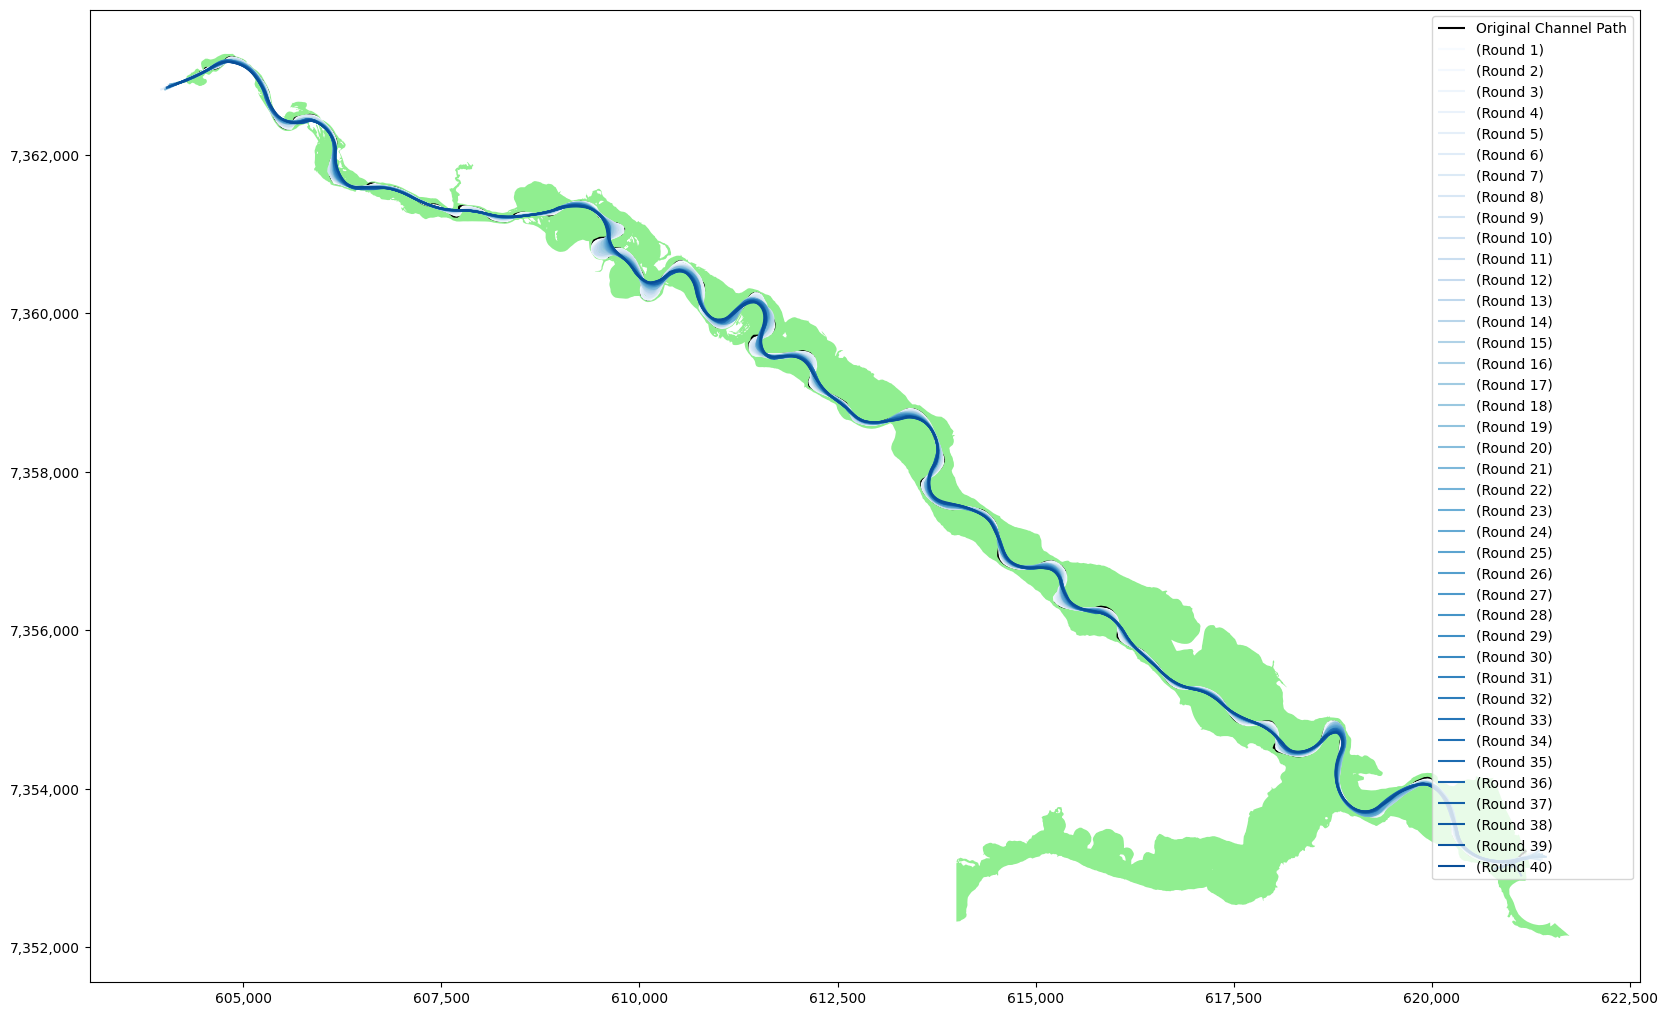

In [72]:
#ALGORITMI 
#REVERSE MIGRATION

import numpy as np
from shapely.geometry import Point

def reverse_migration_simulation(N_s, channel_path, p_before_next_inflectionpoint, feasible_region):
    new_points = {}
    nurbs = {}
    nurbs_gdf = {}
    blacklist = []

    for sk in range(N_s):
        # Initialize a GeoDataFrame to store the new points
        new_points[sk] = gpd.GeoDataFrame(columns=['geometry', 'curvature', 'halfmeander'])
    
        # Inflection points of the current channel path
        inflection_points = define_inflectionpoints(channel_path['geometry'], p_before_next_inflectionpoint)
        # Define halfmeanders
        define_halfmeander(channel_path, inflection_points)
        # Add into new_points
        new_points[sk]['halfmeander'] = channel_path['halfmeander']
        
        radius, interp, sol, A, B = radius_and_intersectionpoint(channel_path)

        # Curvature
        calculate_curvature(channel_path, radius)
        # Add into new_points
        new_points[sk]['curvature'] = channel_path['curvature']
        
        # Define the Nhm number of half-meanders of the current channel path
        N_hm = len(inflection_points) - 1
        
        # Define the migration directions
        D_direction, L_direction = define_directions(inflection_points)

        '''Liikkumisen määrä näitä muuttamalla'''
        
        # Set mean and standard deviation for the Gaussian distribution
        mean_offset = 20
        std_dev_offset = 5

        # Sample horizontal and lateral offsets from Gaussian distribution

        '''Näitä muuttamalla: Pure lateral reverse migration, Pure reverse downstream migration, Mixed reverse migration, Natural reverse migration with probability distribution accepting negative offsets of lateral and downstream migration'''
    
        OD = np.random.normal(mean_offset, std_dev_offset, N_hm)
        #OD = np.zeros(N_hm)

        #OL = np.random.normal(mean_offset, std_dev_offset, N_hm)
        OL = np.zeros(N_hm)


        # Sample smoothing values sL and sD from a uniform distribution
        if np.all(OD) == 0:
            max_od = 0
        else:
            max_od = max(np.abs(OD))
        
        if np.all(OL) == 0:
            max_ld = 0
        else:
            max_ld = max(np.abs(OL))

        min_sD = 0
        max_sD = 2 * max_od

        min_sL = 0
        max_sL = 2 * max_ld

        sD = np.random.uniform(min_sD, max_sD, N_hm)
        
        sL = np.random.uniform(min_sL, max_sL, N_hm)
                            
        # Sample the weighting w
        w = np.random.choice([-1, 1], N_hm) 

        # Initialize a list to store the new points
        newpoint_list = []
        
        for hm in range(N_hm): 
            
            # Filter points of one halfmeander
            pm = (channel_path['halfmeander'] == hm)
            filtered_pm = channel_path[pm]

            mig_D, mig_L = offsets(filtered_pm, OD[hm], OL[hm], sD[hm], sL[hm], w[hm])

            
            #print(OL)
            #print("liikkuu metreissä D-suuntaan :", mig_D)
            #print("liikkuu metreissä L-suuntaan :", mig_L)
        
            #print("pisteet:", filtered_pm['geometry'])
            #print("D-suunta:", D_direction[hm]) #NÄÄÄ PITÄÄÄÄ TSEKKAA VIEL OIKEIKS
            print("L-suunta: " , L_direction[hm] )

            

            #Move points

            for pn in range(len(filtered_pm['geometry'])):

                if 0 == 0: #??????????????????????????????????? wtf oon ajatellu? parempi ehto kun parillinen pariton hm?

                    new_point = (
                        filtered_pm['geometry'].iloc[pn].x + ((mig_D[pn] * D_direction[hm][0]) + (mig_L[pn] *  L_direction[hm][0])) ,
                        filtered_pm['geometry'].iloc[pn].y + ((mig_D[pn] * D_direction[hm][1]) + (mig_L[pn] *  L_direction[hm][1]))
                        )
                    if not np.isnan(new_point).all():
                        newpoint = check_feasible_region(filtered_pm['geometry'].iloc[pn], new_point, feasible_region)
                        newpoint_list.append(newpoint)
                    else:
                        newpoint = (filtered_pm['geometry'].iloc[pn].x ,  filtered_pm['geometry'].iloc[pn].y)
                        newpoint_list.append(Point(newpoint)) 
             
                    
                else:
                    new_point = (
                        filtered_pm['geometry'].iloc[pn].x + ((mig_D[pn] * D_direction[hm][0]) + (mig_L[pn] *  -L_direction[hm][0])) ,
                        filtered_pm['geometry'].iloc[pn].y + ((mig_D[pn] * D_direction[hm][1]) + (mig_L[pn] *  -L_direction[hm][1]))
                        )
                    if not np.isnan(new_point).all():
                        newpoint = check_feasible_region(filtered_pm['geometry'].iloc[pn], new_point, feasible_region)
                        newpoint_list.append(newpoint)
                    else:
                        newpoint = (filtered_pm['geometry'].iloc[pn].x ,  filtered_pm['geometry'].iloc[pn].y)
                        newpoint_list.append(Point(newpoint)) 
                
        # Add new points to the GeoDataFrame
        new_points[sk]['geometry'] = newpoint_list

        # NURBS line of new points
        nurbs[sk], nurbs_gdf[sk] = create_nurbs((new_points[sk]['geometry']).apply(lambda point: (point.x, point.y)).tolist())

        # update new path to next round
        channel_path = create_breakpoints(nurbs[sk], 75)
        
        
    #print(uudet_pisteet)   

        
    #kuvakoko
    fig, ax = plt.subplots(figsize=(20, 15))

        # x ja y akselit
    def format_eastings(value, pos):
        return f'{int(value):,}'

    def format_northings(value, pos):
            return f'{int(value):,}'

    ax.xaxis.set_major_formatter(FuncFormatter(format_eastings))
    ax.yaxis.set_major_formatter(FuncFormatter(format_northings))


    sallittu_alue.plot(ax=ax, color = 'lightgreen')


    # Plot the original channel_path
    joen_keskiviiva.plot(ax=ax, color='black', label='Original Channel Path')
    #channel_path.plot(ax=ax, cmap='jet', markersize=8)
    
    # Plot the moved points on the same axis
    #for i in range (len(new_points)):
    #    new_points[i].plot(ax=ax, color=f'C{i}', label=f'Moved Points (Round {i+1})', markersize = 20)

    # Plot the moved points on the same axis
    for i in range (len(new_points)):
        gradient = np.linspace(0, 1, len(new_points)+5)
        color = plt.cm.Blues(gradient[i])
        # Plottaa NURBS-viiva
        gpd.GeoDataFrame(geometry=[nurbs[i]]).plot(ax=ax, color=color, label=f'(Round {i+1})')

    
    plt.legend()

    plt.show()

      
# Input
N_r = 1
N_s = 40

channel_path = pisteet100
p_before_next_inflectionpoint = 5

sallittu_alue = sallittu_alue

reverse_migration_simulation(N_s, channel_path, p_before_next_inflectionpoint, sallittu_alue)





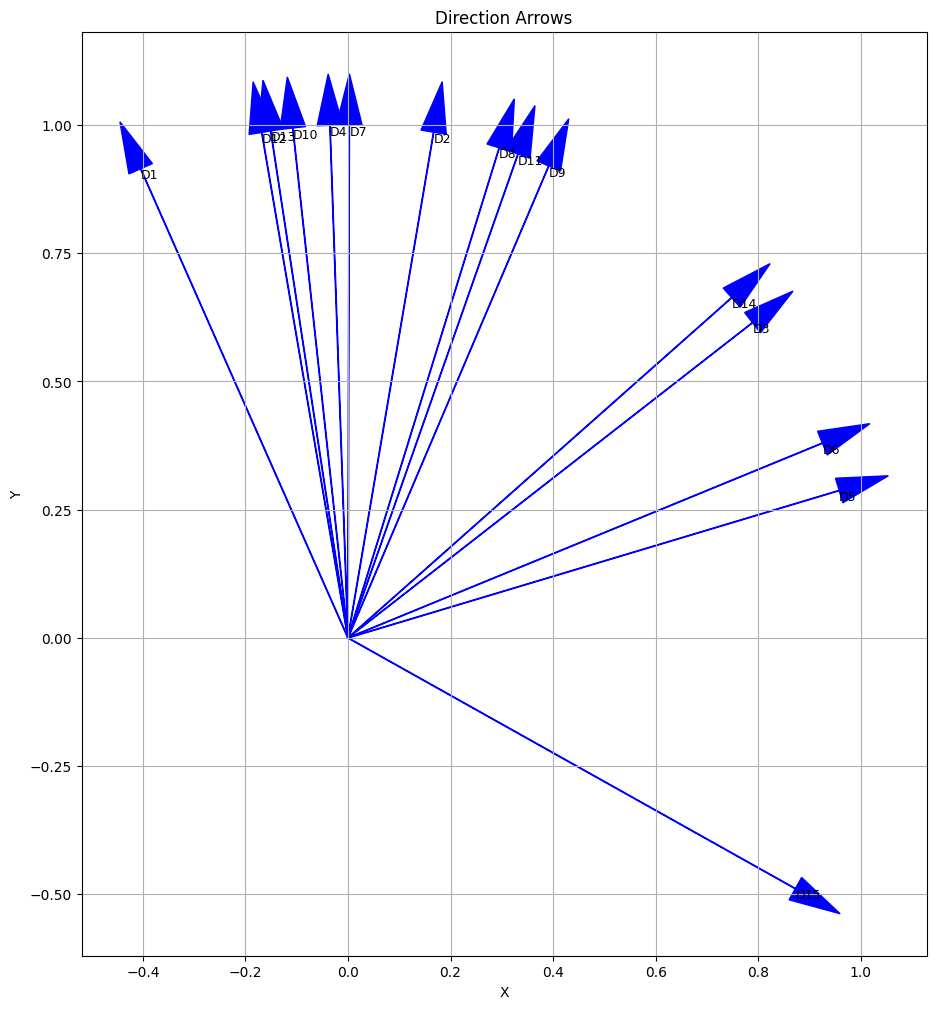

In [74]:
import matplotlib.pyplot as plt

# Define direction vectors
directions = [
    (-0.4041319004897346, 0.9147007199114665),
    (0.16706576543969406, 0.9859457540950461),
    (0.7888150289173815, 0.6146306615798391),
    (-0.03504682352772973, 0.9993856713804817),
    (0.9578343858483133, 0.28732088209279993),
    (0.9250979751749493, 0.3797285034431954),
    (0.0025576298301197824, 0.9999967292594771),
    (0.2949566598344096, 0.9555106324993607),
    (0.39147366000077405, 0.9201893139596864),
    (-0.1074892260655016, 0.9942062493667195),
    (0.3315649201837805, 0.9434324054766846),
    (-0.16808679417206096, 0.9857721996612397),
    (-0.15062283827058331, 0.9885913010902502),
    (0.7482899696997022, 0.6633717820700687),
    (0.8723313310795955, -0.4889151754823132)
]

# Plot direction arrows
plt.figure(figsize=(13, 12))
for i, (dx, dy) in enumerate(directions):
    plt.arrow(0, 0, dx, dy, head_width=0.05, head_length=0.1, fc='blue', ec='blue')
    plt.text(dx, dy, f'D{i+1}', fontsize=9, ha='left', va='top')


plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Direction Arrows')
plt.grid(True)
plt.show()

